# Libraries

In [2]:
# Lets install catboost for creating a model
!pip install catboost --quiet

In [3]:
!pip install sweetviz

In [16]:
import os, warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error, mean_squared_log_error,log_loss
from sklearn.model_selection import train_test_split,KFold, GroupKFold, StratifiedKFold

# Fitting the data to model
from catboost import CatBoostClassifier

from time import sleep

In [5]:
import numpy, pandas, catboost, sklearn

In [6]:
print("numpy: ", numpy.__version__) #1.19.5
print("pandas: ", pandas.__version__) #1.1.5
print("catboost: ", catboost.__version__) #0.26.1
print("sklearn: ", sklearn.__version__) #0.22.2.post1

numpy:  1.20.3
pandas:  1.4.0
catboost:  1.0.6
sklearn:  0.24.2


# Load Data

In [7]:
# Load the data
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_riders = pd.read_csv('Riders.csv')


# Variable definitions
## Dispatch Data:

* **ID** - Unique ID for each order request
* **order_id** – Unique number identifying the order
* **client_id** - Unique number identifying the customer on a platform
* **client_type** - Specifies the customer type (Business or Personal)
* **rider_id** - Unique number to uniquely identify the rider
* **rider_license_status** - Identifies riders who have a license to access restricted areas i.e. 0 (Cannot access a - - restricted area) and 1 (Can access a restricted area)
* **rider_carrier_type** - Identifies the box option that a rider currently has i.e. 0 (No Box option) and 1 (Box option)
* **rider_amount** - The earnings a partner would earn if they successfully complete an order.
* **order_license_status** - Identifies orders that require a pick-up or drop-off in a restricted area i.e. 0 (Restricted area) and 1 (Non-Restricted area)
* **order_carrier_type** - Identifies the box option the customer specified while placing their orders i.e. 0 (No box option), 1 (Box option), 2 (Any option)
* **vendor_type** – For this competition limited to bikes. However, in practice, Sendy’s service extends to Vans and Trucks.
* **Pickup Latitude and Longitude (pickup_lat and pickup_long)** - Latitude and longitude of pick up location
* **Destination Latitude and Longitude (drop_off_lat and drop_off_long)** - Latitude and longitude of delivery location
* **Rider Latitude and Longitude (rider_lat and rider_long)** - Latitude and longitude of the Rider at the time of dispatch.
* **target** - The reaction of a rider in regards to a particular dispatch. Did a rider ignore (0), decline (1) or accept (2) a dispatch?
### Dispatch times:

* **dispatch_day** - Day of Month i.e. 1-31
* **dispatch_day_of_week** - Weekday (Monday = 1)
* **dispatch_time** - Time of day the dispatch was sent out to the riders

# EDA

In [8]:
# Creating Copy to work with
train = df_train.copy()
test = df_test.copy()
riders = df_riders.copy()

In [9]:
# %data informations
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179867 entries, 0 to 179866
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    179867 non-null  object 
 1   order_id              179867 non-null  int64  
 2   dispatch_day          179867 non-null  int64  
 3   dispatch_day_of_week  179867 non-null  int64  
 4   dispatch_time         179867 non-null  object 
 5   client_id             179867 non-null  int64  
 6   client_type           179867 non-null  object 
 7   order_license_status  179867 non-null  int64  
 8   order_carrier_type    179867 non-null  int64  
 9   vendor_type           179867 non-null  object 
 10  rider_id              179867 non-null  int64  
 11  rider_license_status  179867 non-null  int64  
 12  rider_carrier_type    179867 non-null  int64  
 13  rider_amount          179867 non-null  int64  
 14  rider_lat             179867 non-null  float64
 15  

In [10]:
# %inspect statistical relationship for numeric features
train.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,179867.0,32639.833149,18227.428596,100.000000,16875.000000,32964.000000,48117.000000,6.442700e+04
dispatch_day,179867.0,16.604903,8.528368,1.000000,9.000000,17.000000,24.000000,3.100000e+01
dispatch_day_of_week,179867.0,4.185198,1.683574,1.000000,3.000000,4.000000,6.000000,7.000000e+00
client_id,179867.0,465410.752400,663423.434197,261.000000,75647.000000,143428.000000,593630.000000,2.568456e+06
order_license_status,179867.0,0.239555,0.426813,0.000000,0.000000,0.000000,0.000000,1.000000e+00
order_carrier_type,179867.0,1.619007,0.536552,0.000000,1.000000,2.000000,2.000000,2.000000e+00
rider_id,179867.0,70389.969944,33981.806096,1817.000000,40756.000000,73485.000000,100441.000000,1.236940e+05
rider_license_status,179867.0,0.589936,0.491846,0.000000,0.000000,1.000000,1.000000,1.000000e+00
rider_carrier_type,179867.0,0.868731,0.337695,0.000000,1.000000,1.000000,1.000000,1.000000e+00
rider_amount,179867.0,517.544185,157.385430,200.000000,410.000000,460.000000,570.000000,2.190000e+03


In [11]:
# Determining the no. of records in our datasets
print('The train dataset has ', train.shape[1], ' columns and ', train.shape[0], ' rows!')
print('The test dataset has ', test.shape[1], ' columns and ', test.shape[0], ' rows!')
print('The test dataset has ', riders.shape[1], ' columns and ', riders.shape[0], ' rows!')

The train dataset has  21  columns and  179867  rows!
The test dataset has  20  columns and  76791  rows!
The test dataset has  4  columns and  2632  rows!


In [12]:
# Separate target variable 
target = train['target']

In [13]:
# Drop target column then join Train and test
train.drop('target',axis = 1, inplace = True)

# Merge the train and test dataframe
frames = [train,test]
df = pd.concat(frames)

In [14]:
# Checking unique values and number of rows asigned for each column in the dataset
for i in df.columns:
  
  print('\n')
  
  print(i,df[i].nunique())

  print(i,df[i].unique())



ID 256658
ID ['ID_SCUW21PVAU' 'ID_2HA7X30JMN' 'ID_IAJWDTBY6M' ... 'ID_VDI8L0SWNS'
 'ID_7L22AF1T6K' 'ID_LMMA33Q7YL']


order_id 64326
order_id [ 4435 32711  8712 ... 11467 12867 12617]


dispatch_day 31
dispatch_day [27 30 14 22  3 18 28 20  6 12 17  7  5  1 15 31 16  4 25 19 11 23 21  9
 13 10 26  2  8 29 24]


dispatch_day_of_week 7
dispatch_day_of_week [6 7 2 3 5 4 1]


dispatch_time 5788
dispatch_time ['09:02:54' '13:01:37' '10:01:00' ... '06:09:58' '20:08:49' '05:09:47']


client_id 5457
client_id [ 593630  837729  695129 ...  676936 2533910 2361571]


client_type 2
client_type ['Business' 'Personal']


order_license_status 2
order_license_status [0 1]


order_carrier_type 3
order_carrier_type [2 1 0]


vendor_type 1
vendor_type ['Bike']


rider_id 775
rider_id [ 30153  20884  33143  96531 103546  66125  66033  45701 117622  40066
  74842  93610   9729 117093  80132  93633 117760 115184  62445 118082
  76406   5865 118588 100441   7383 105892  66010 106398 100855  64561
  53521  

### PERFORM INITIAL SWEETVIZ ANALYSIS TO GET A FEEL OF THE DATA

                                             |          | [  0%]   00:00 -> (? left)


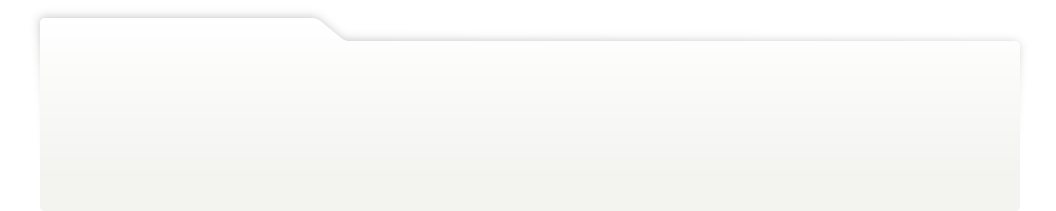
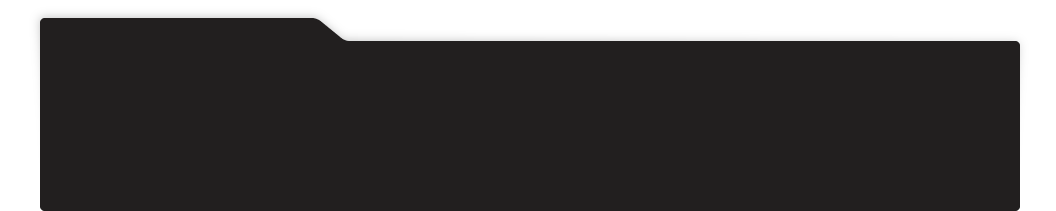
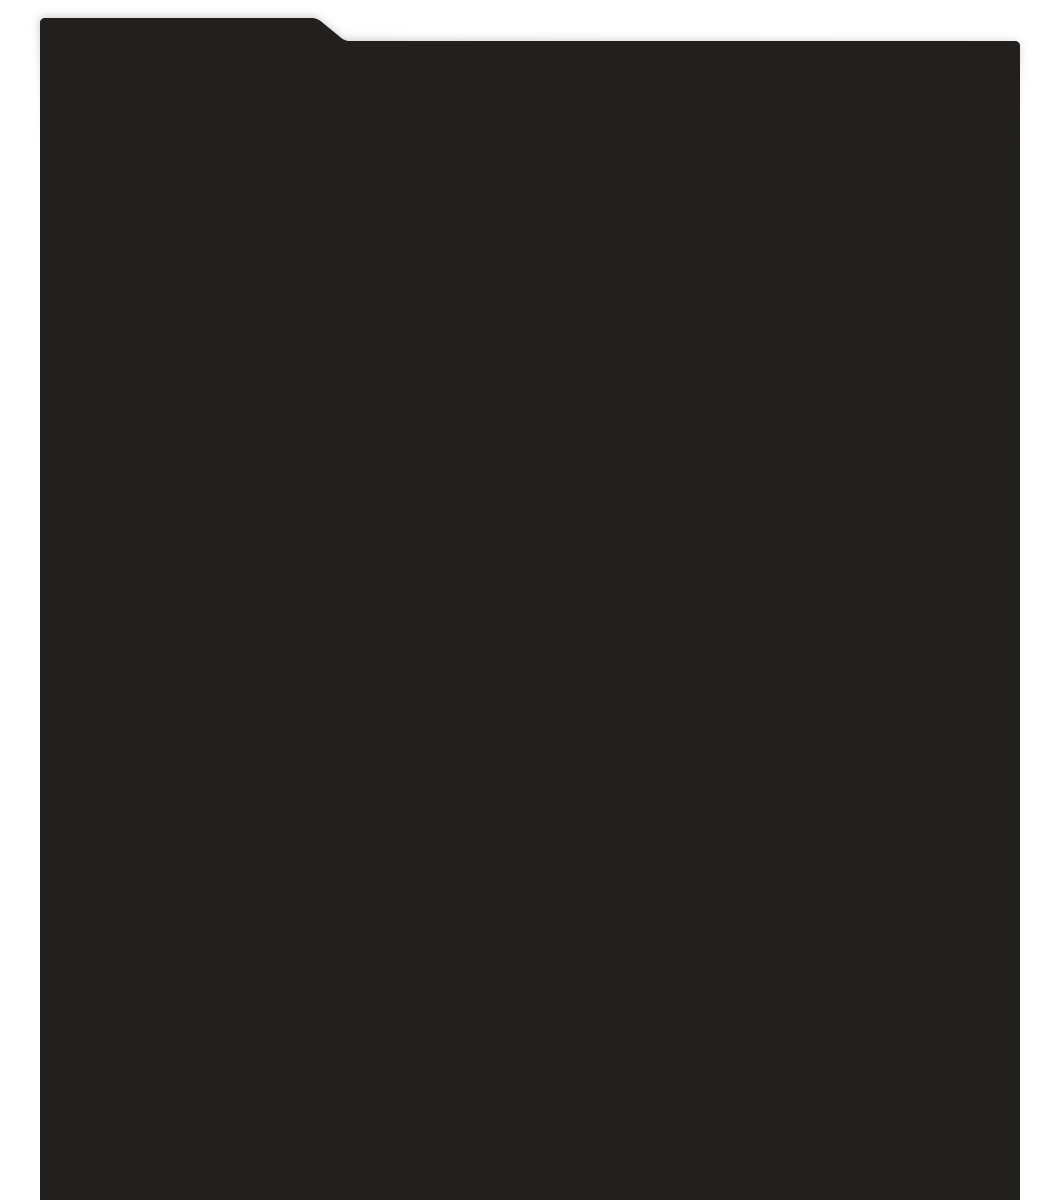
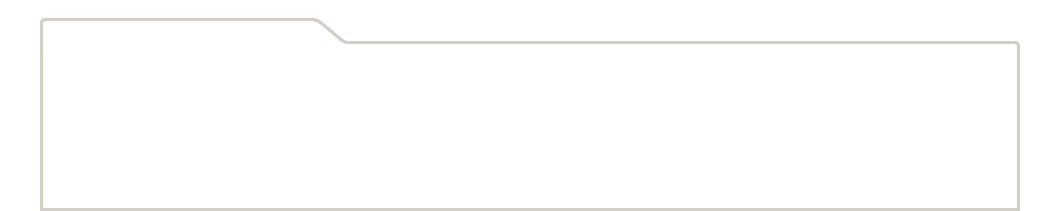
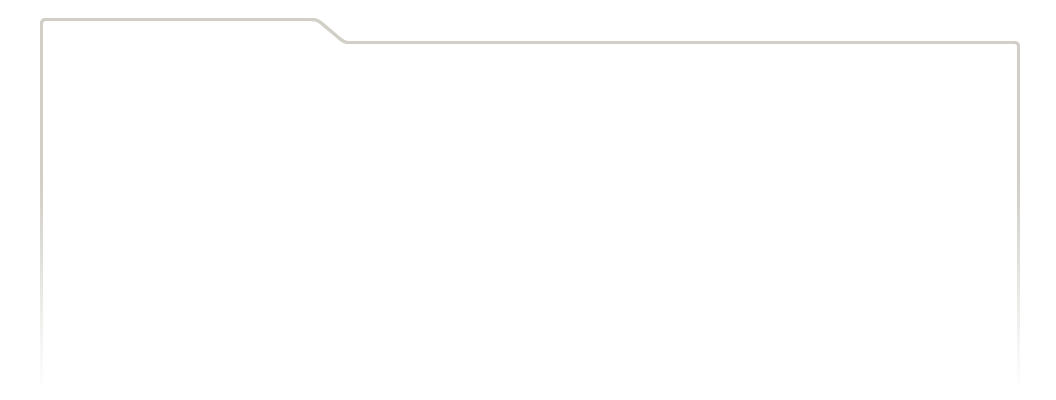
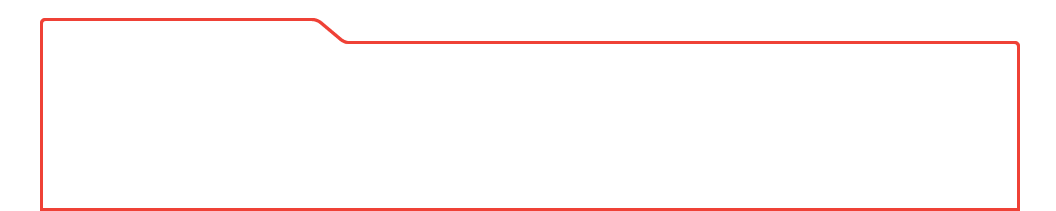
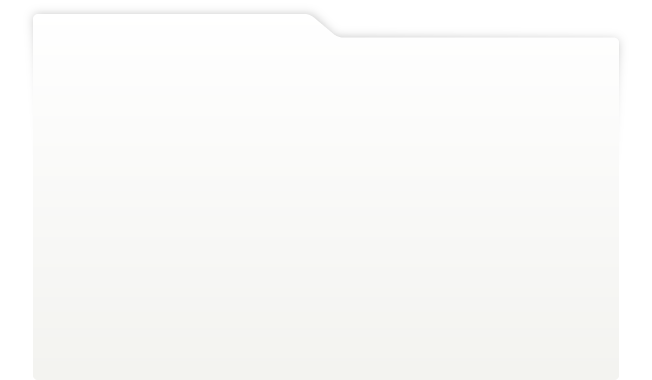
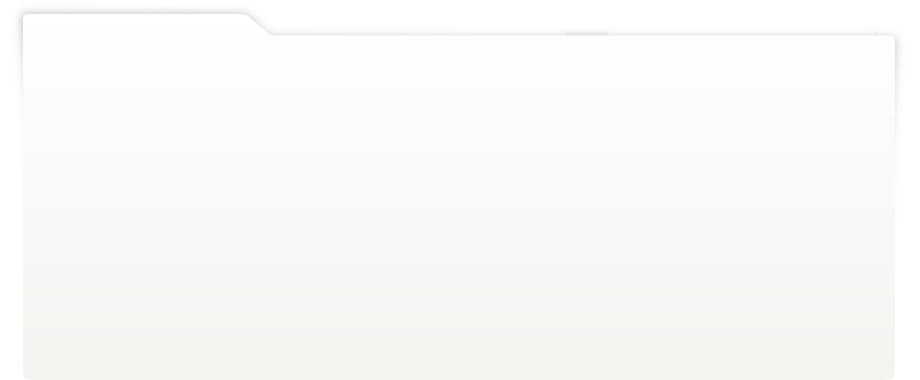
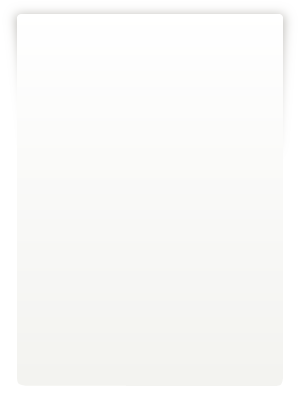
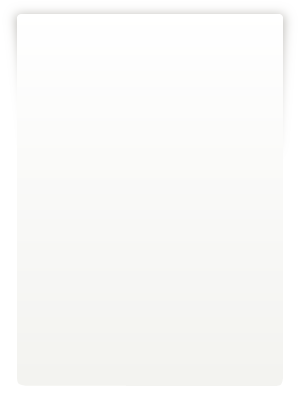
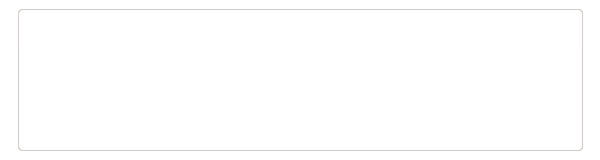
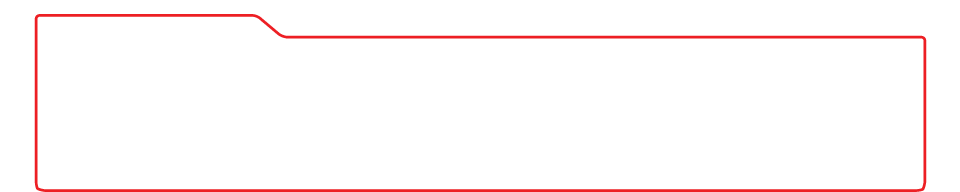
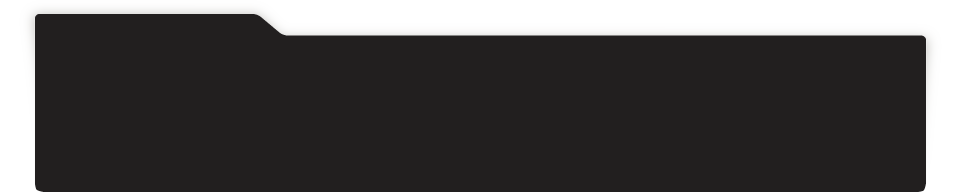
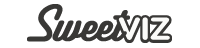
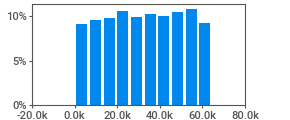
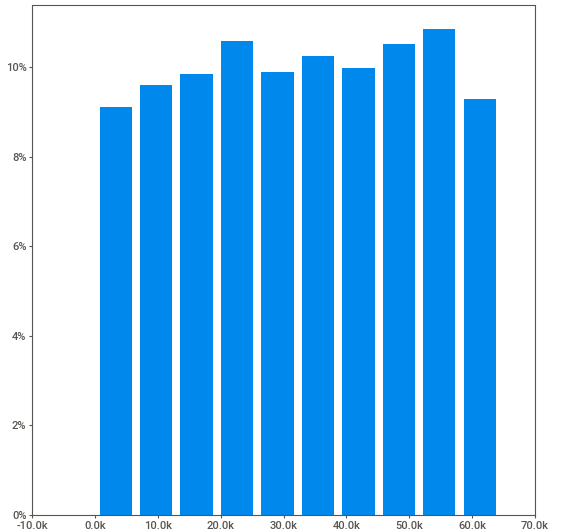
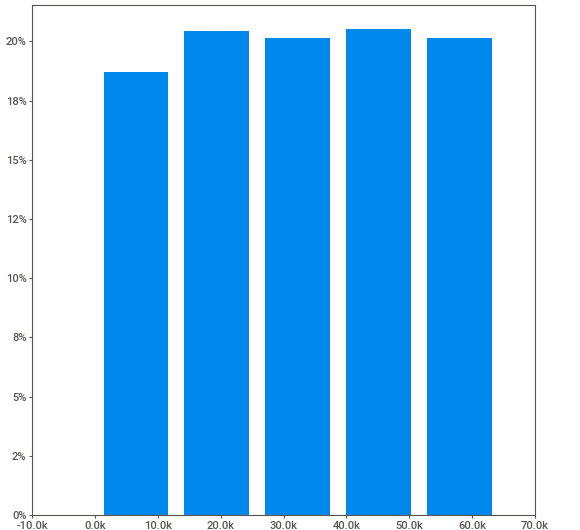
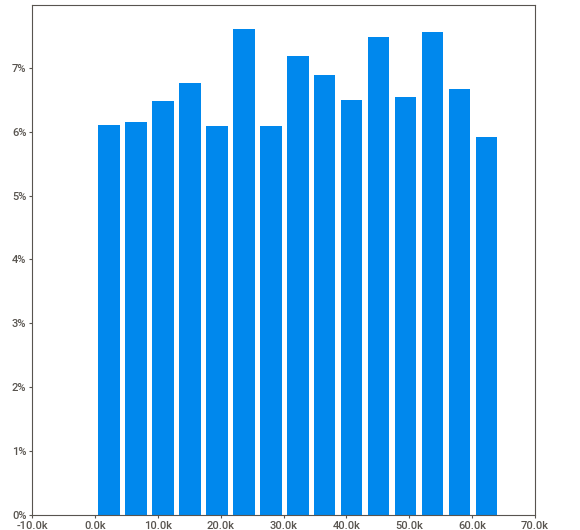
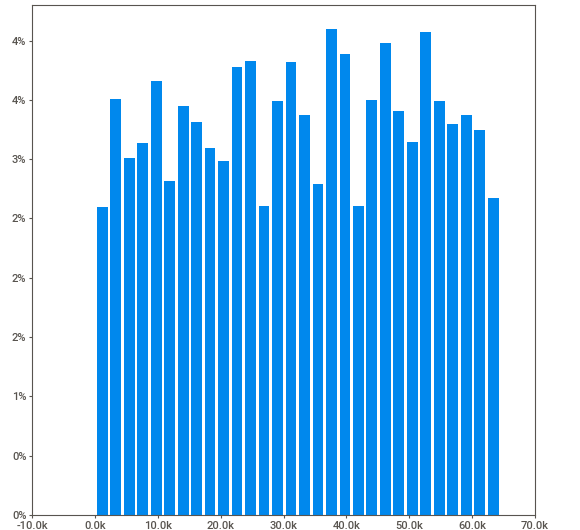
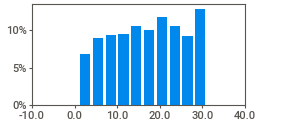
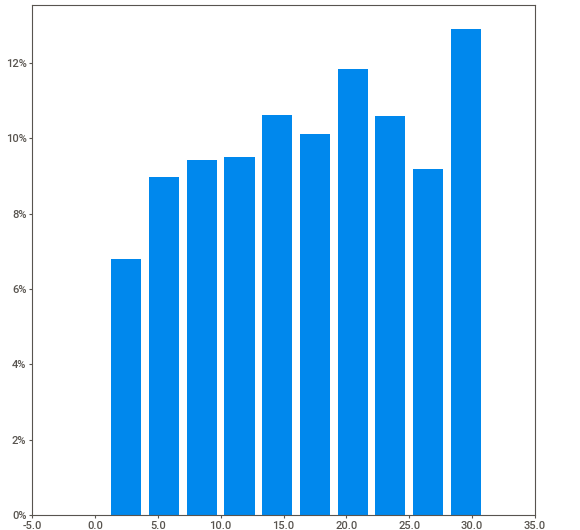
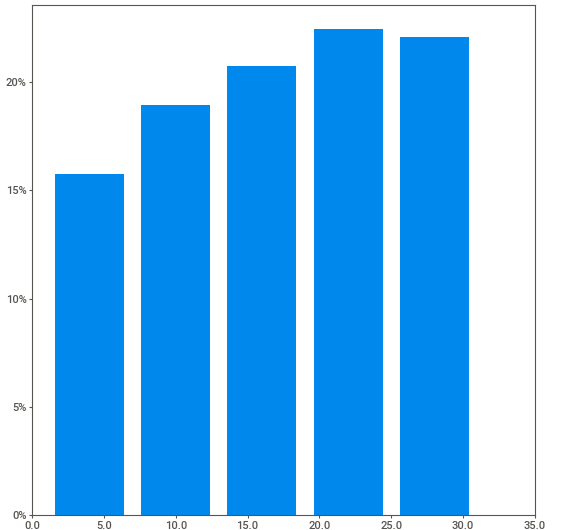
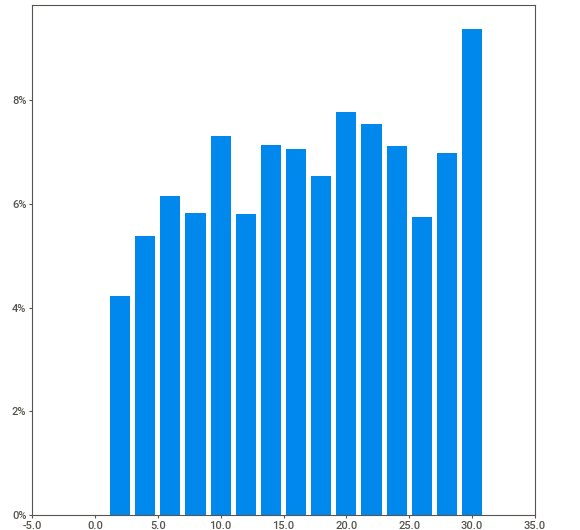
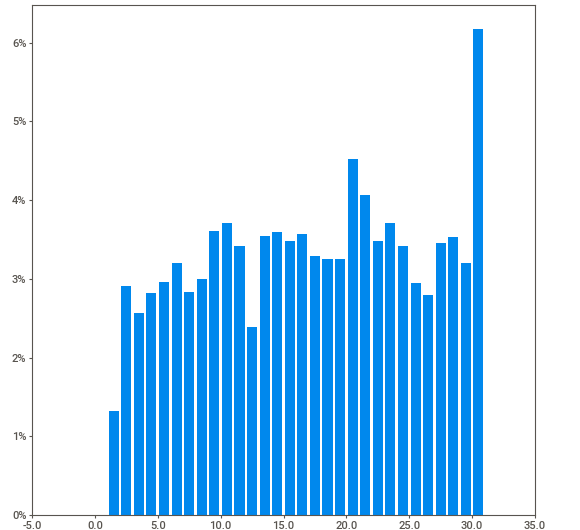
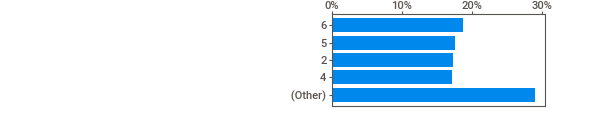
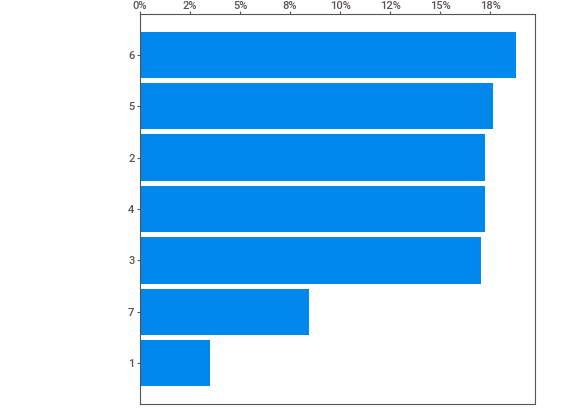
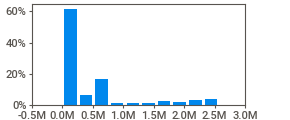
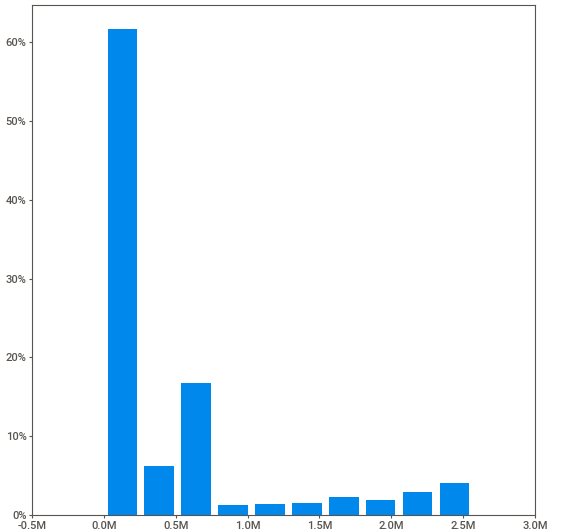
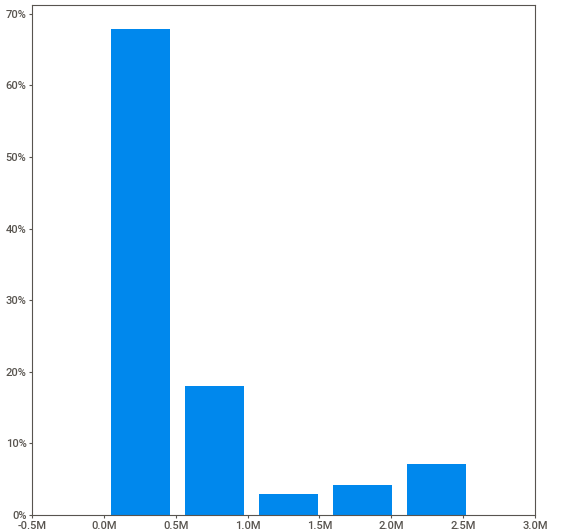
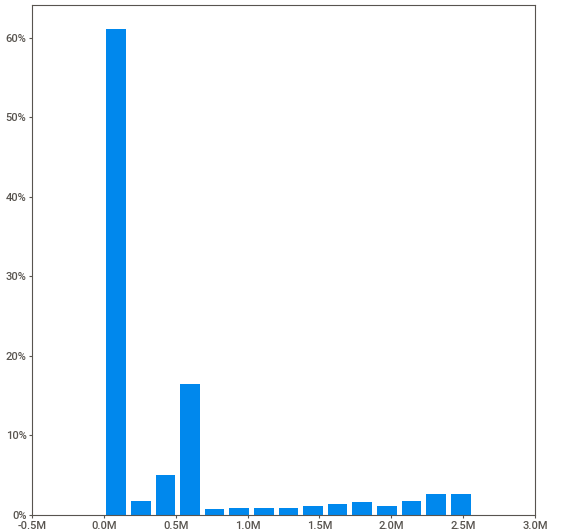
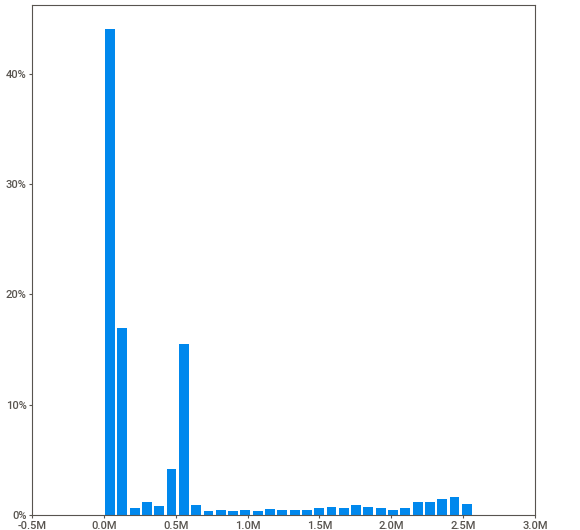
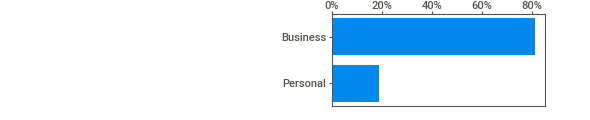
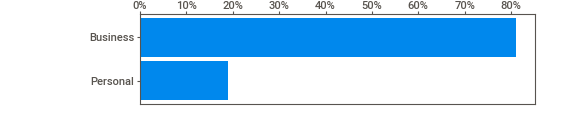
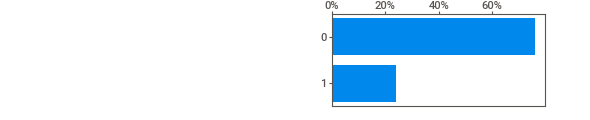
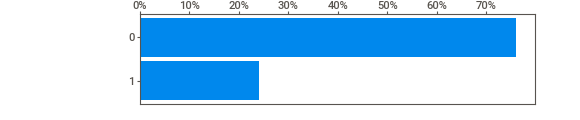
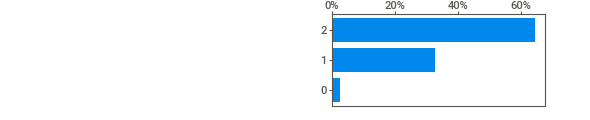
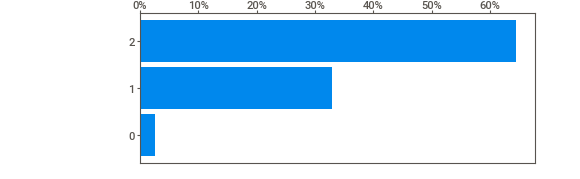
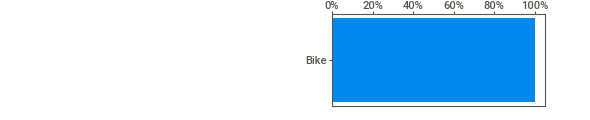
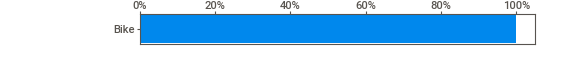
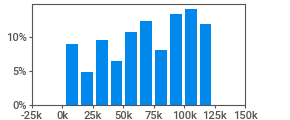
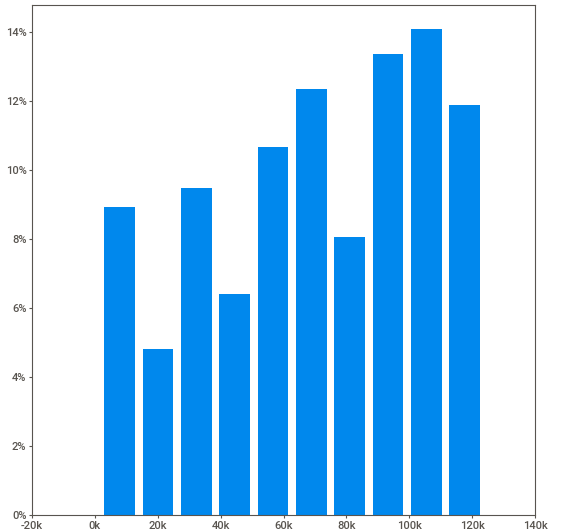
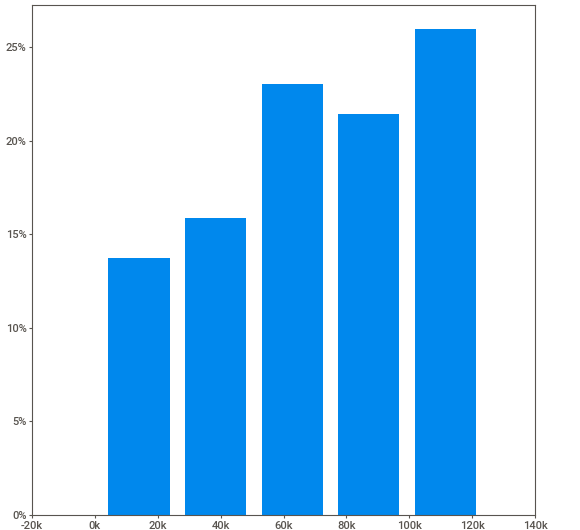
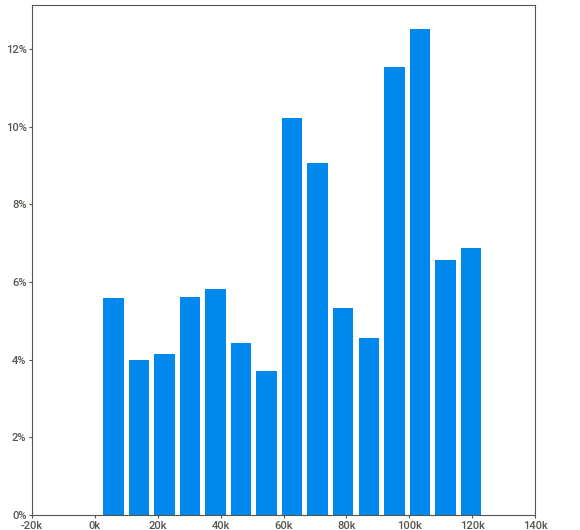
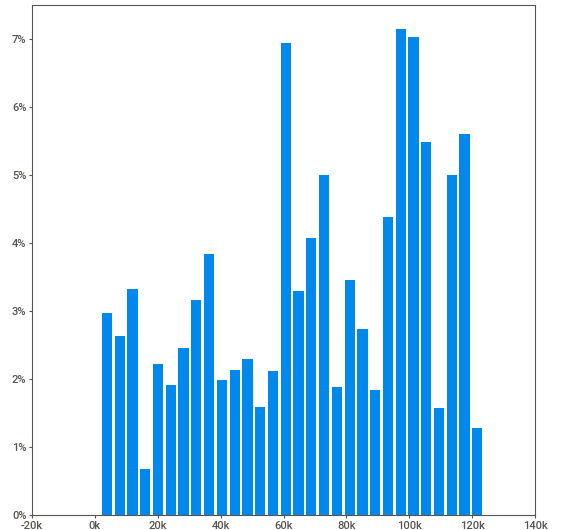
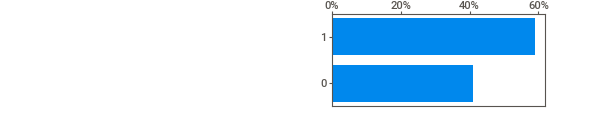
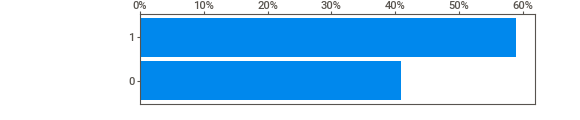
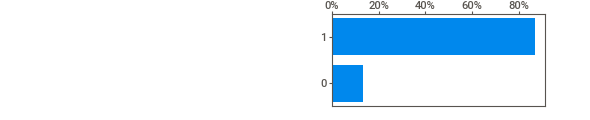
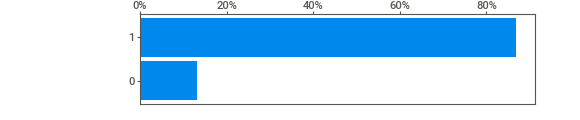
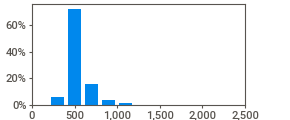
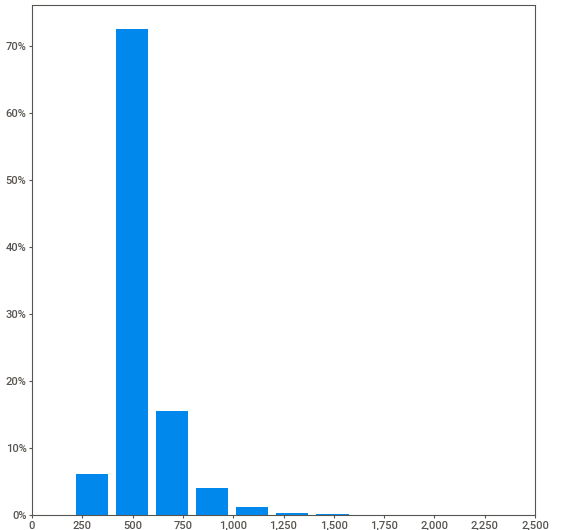
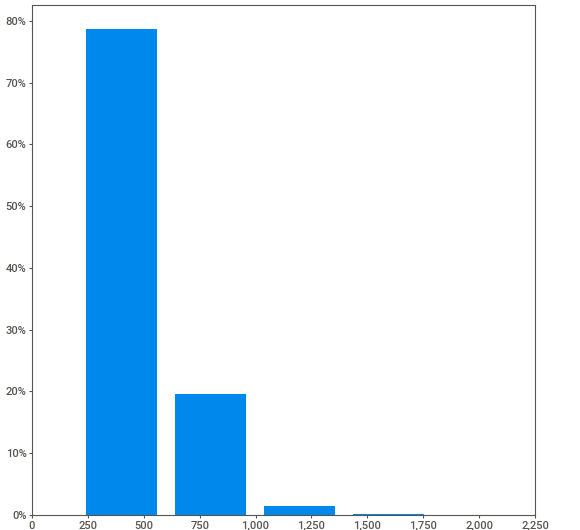
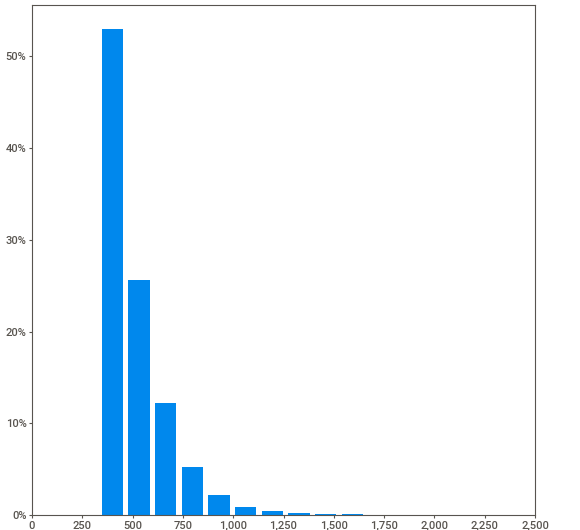
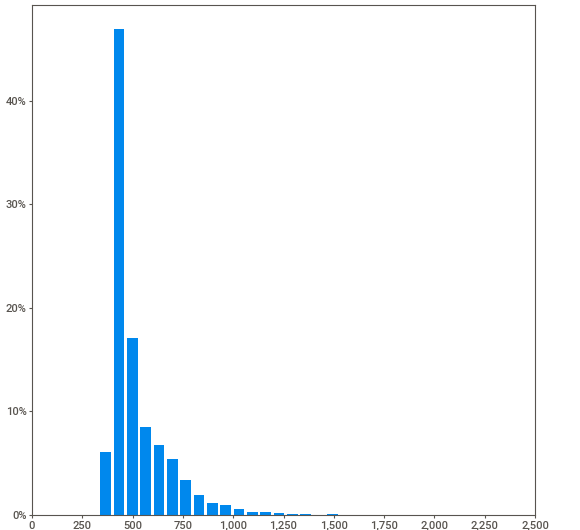
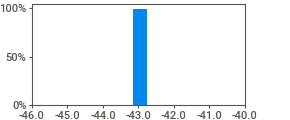
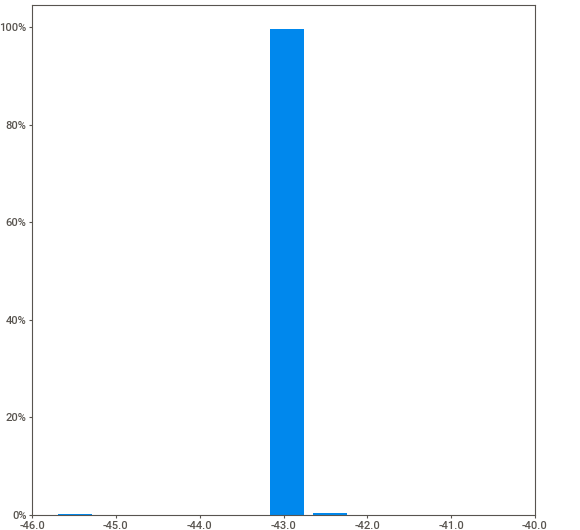
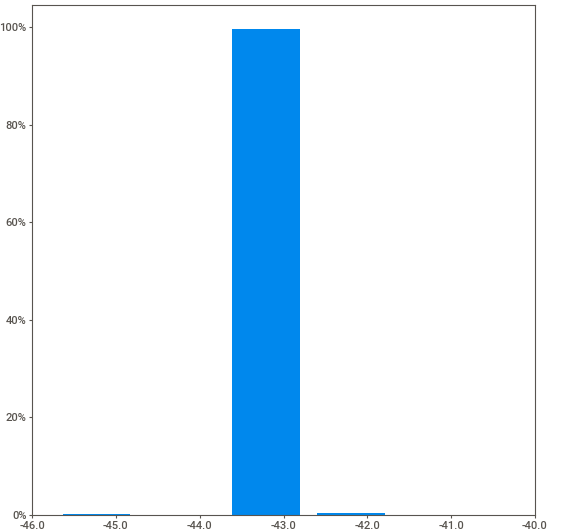
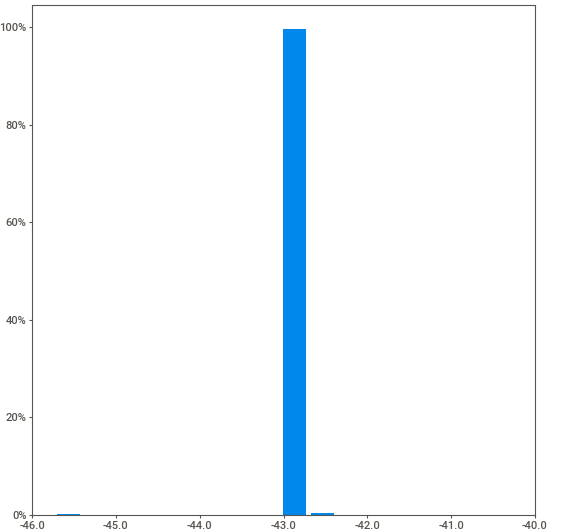
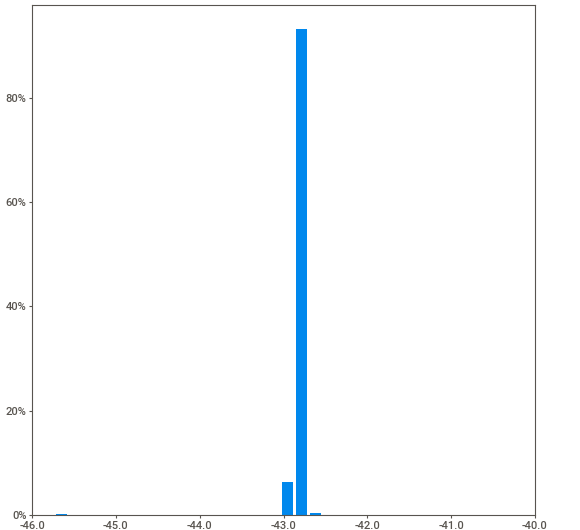
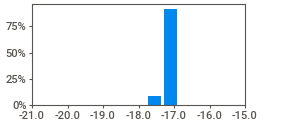
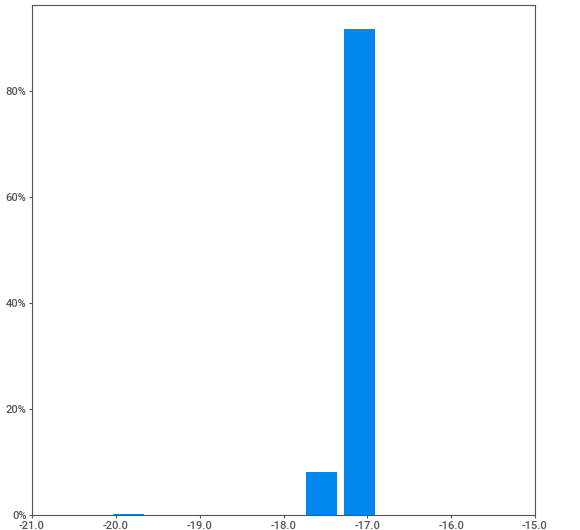
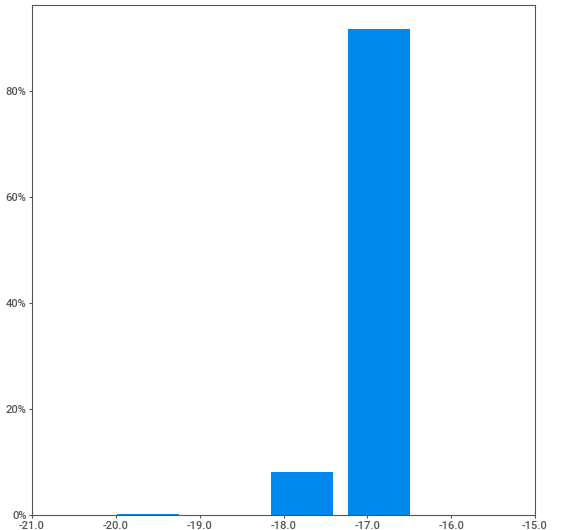
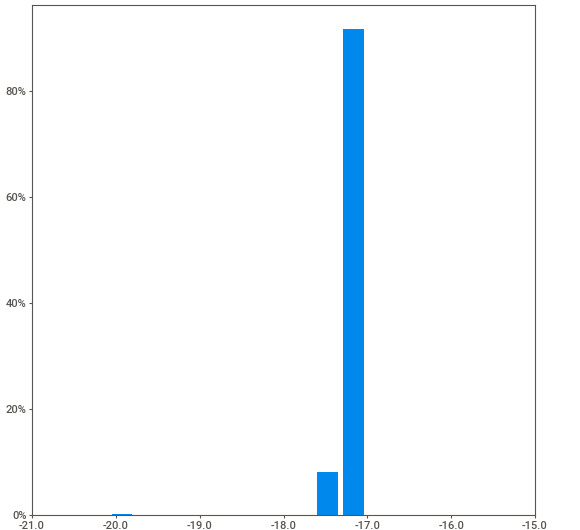
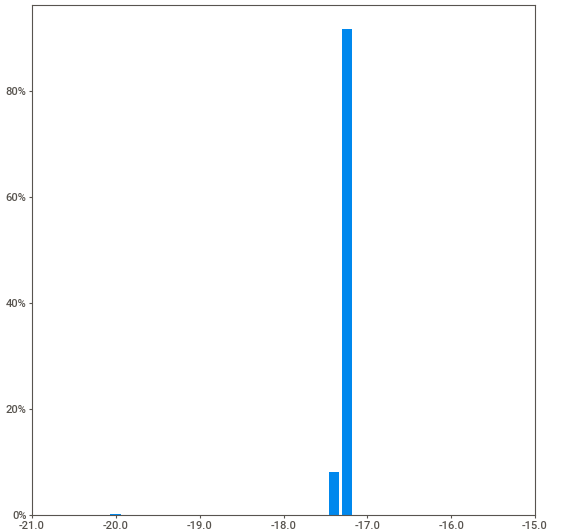
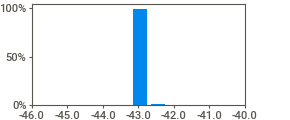
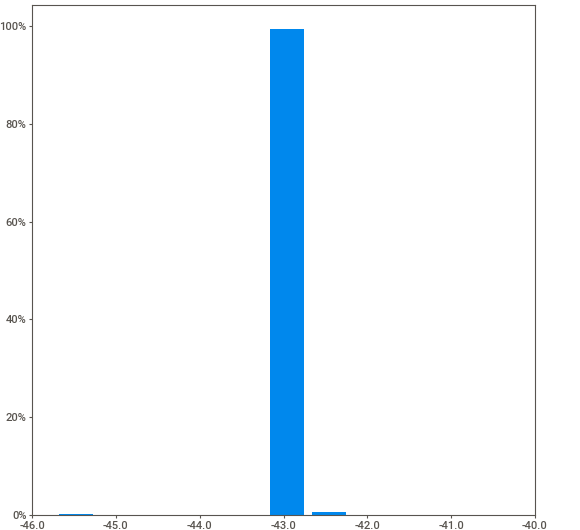
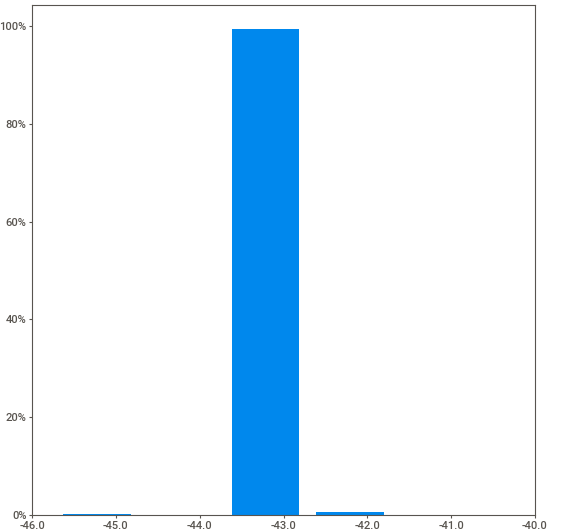
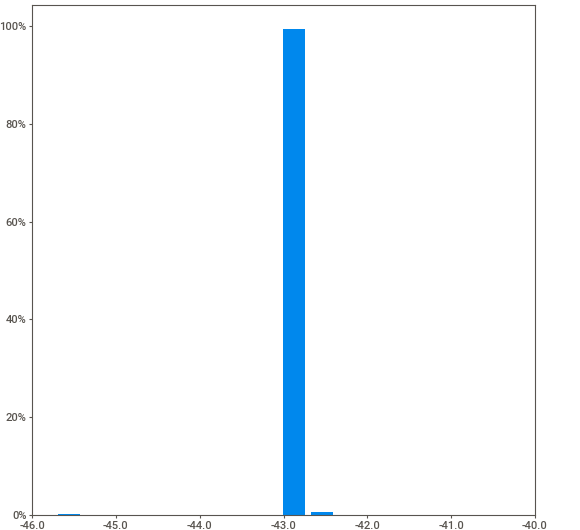
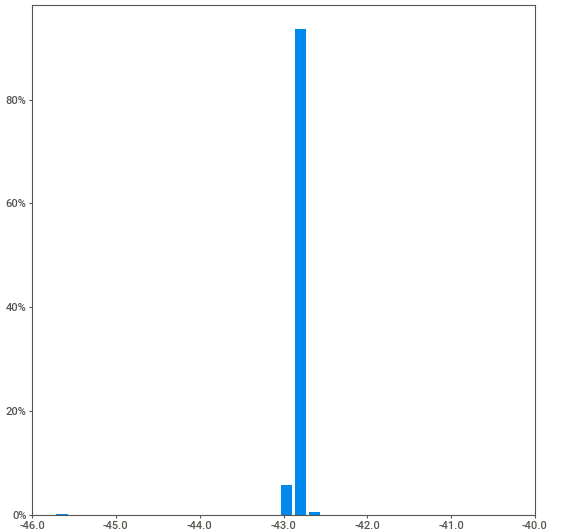
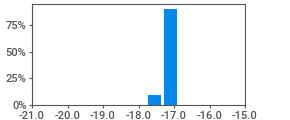
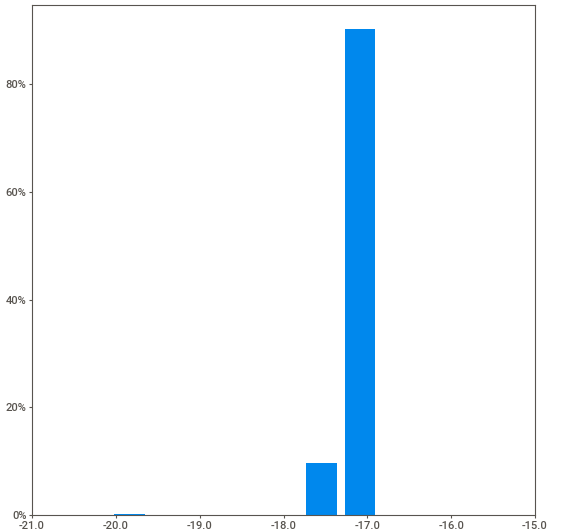
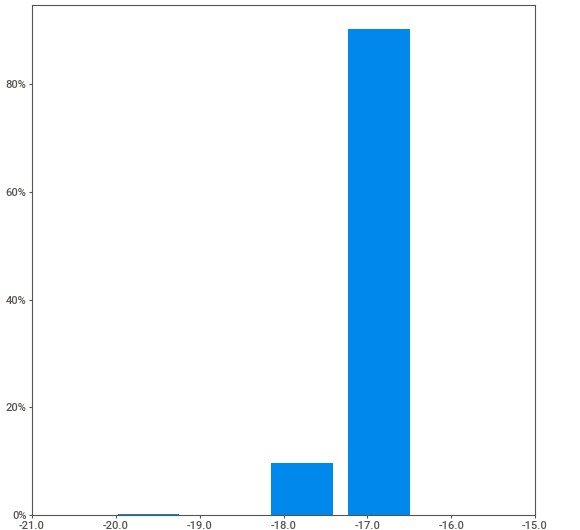
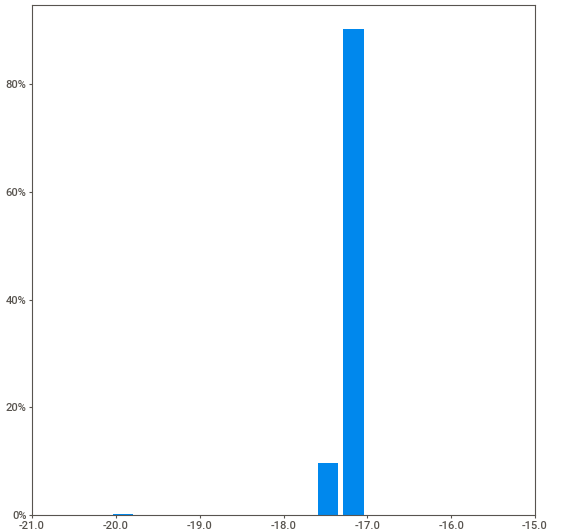
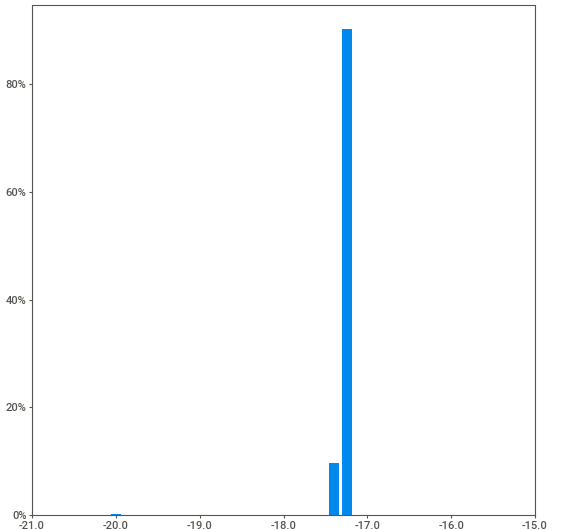
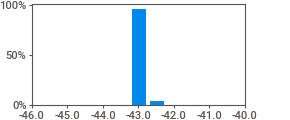
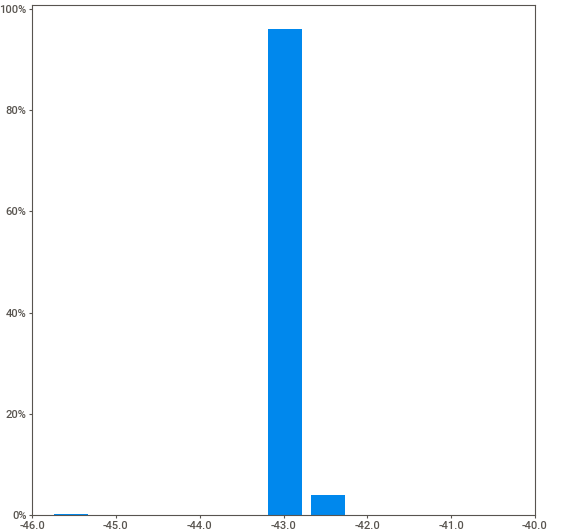
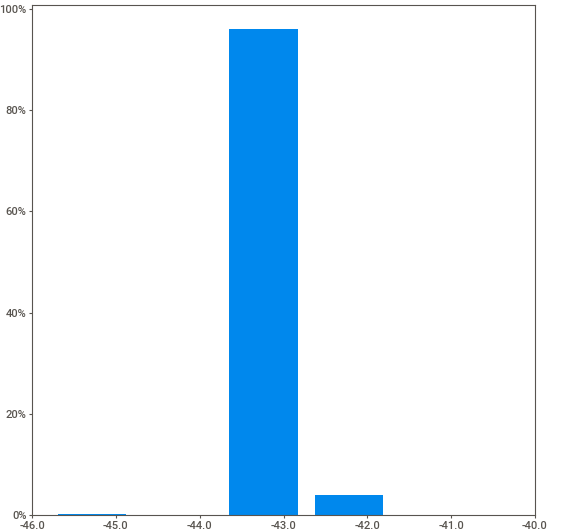
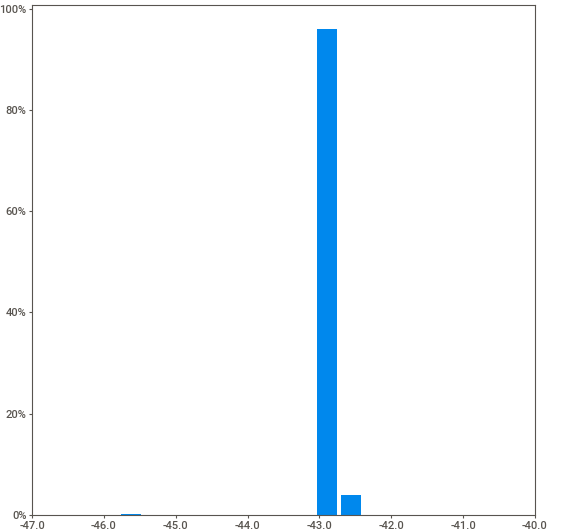
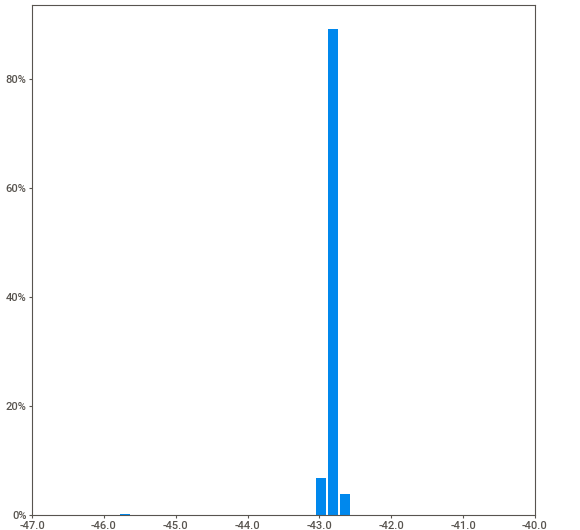
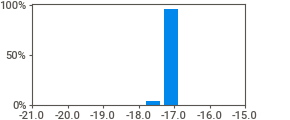
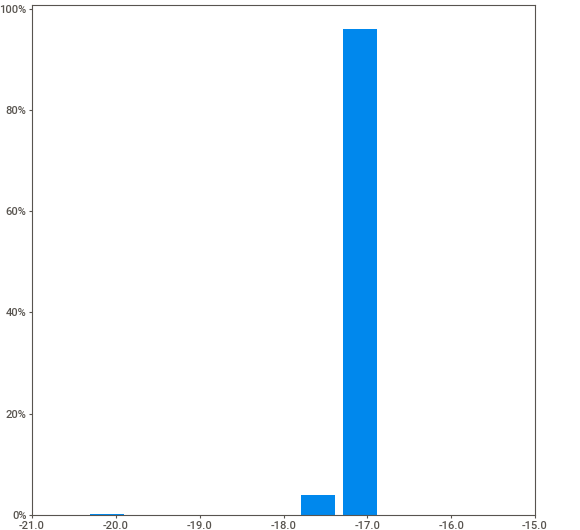
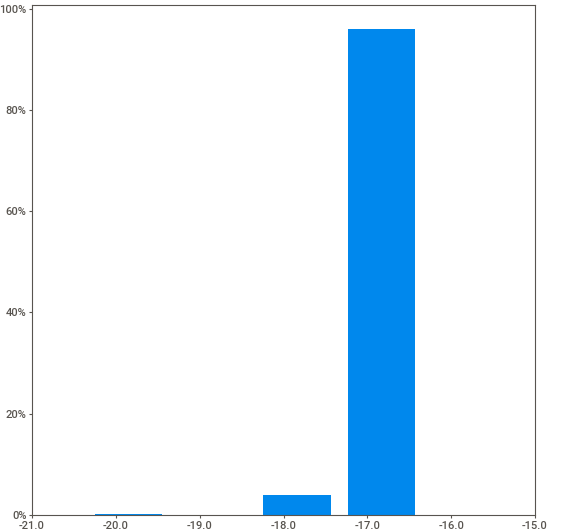
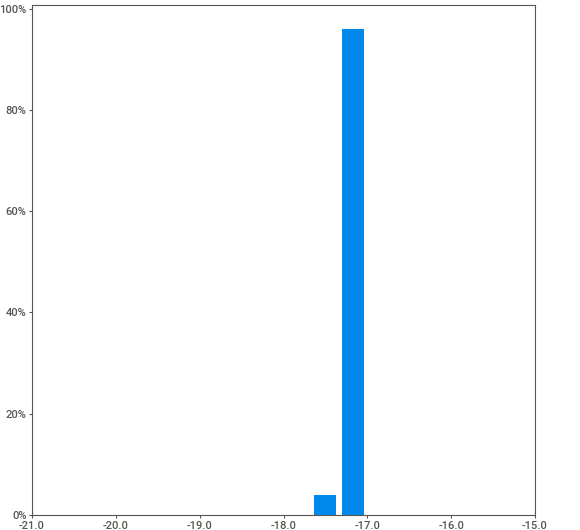
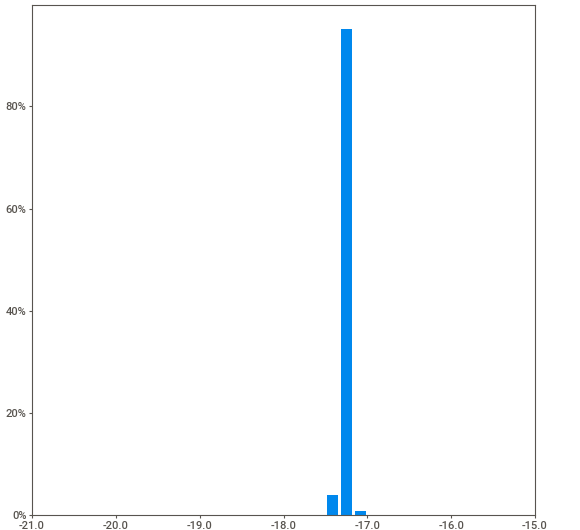
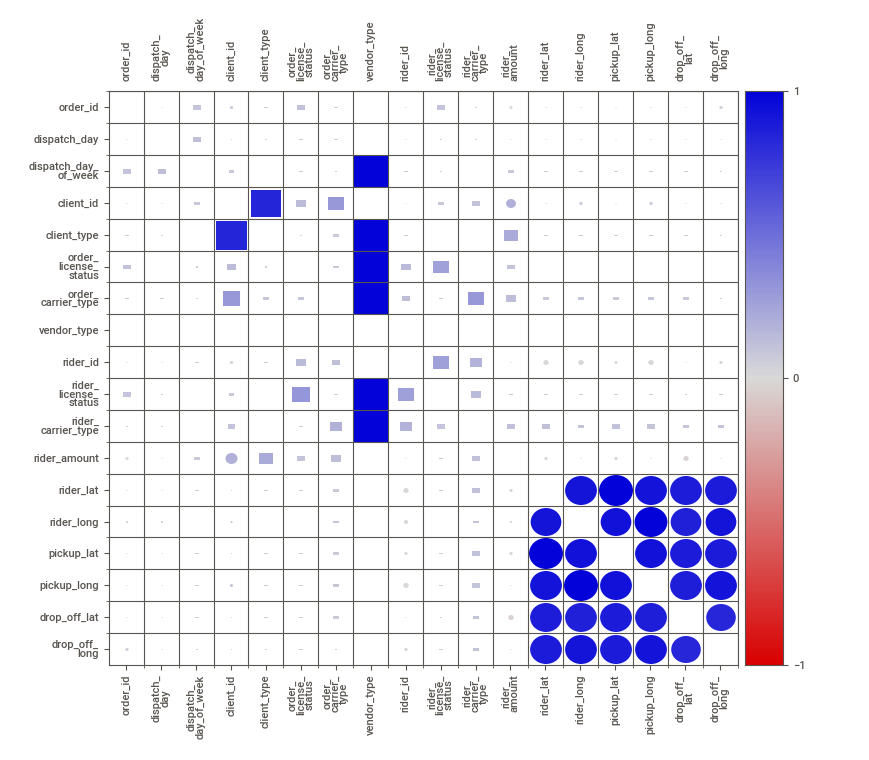
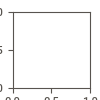

In [17]:
# %perform EDA analysis
train_report = sv.analyze(train)
train_report.show_notebook()

### ANALYSIS
#### OBSERVATION
* No any missing entry and No dublicates entries
* 8 of features are categorical and 11 are numerical features
* Labels are not well balanced, most of riders ignored and rejected the orders(80%), Only few of them tend to accept orders across the platform(20%).
* The data collected based on one vendor type which is Bike.
* Most of riders(rider_lisence_status) can access restricted areas and few of them can't
* Most of riders has carrier type of box and few of them has other type of carriers
* The platform has two types of clients where Business type dominated across the platform(81%) and few are Personal clients.
* Most of orders placed across the platform require a pick-up or drop-off in a restricted area so it need a rider to have licence.
* Most of customers place order for any carrier option, 30% of orders require rider to have box carrier and 3% require a rider to have no box carrier
* Friday and Saturday are days that lead on the number of orders
* Also more order on the end days of the month(27,28,29,30 and 31)

                                             |          | [  0%]   00:00 -> (? left)


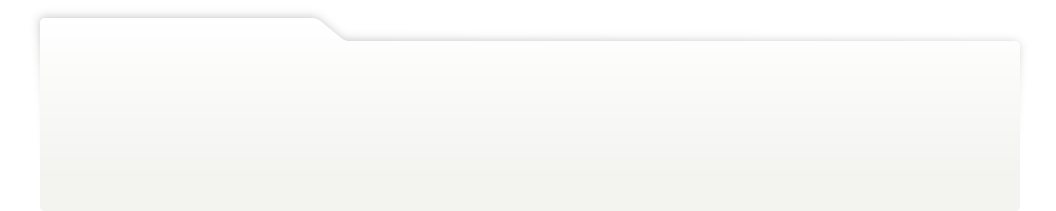
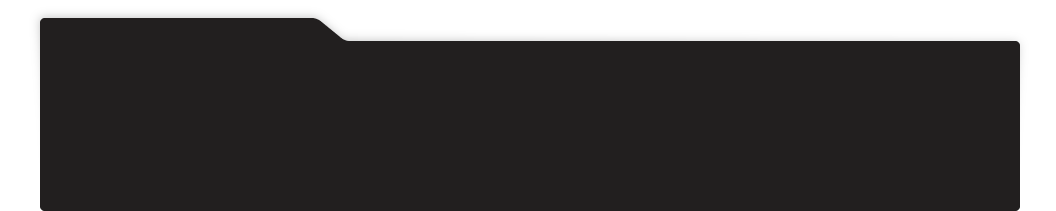
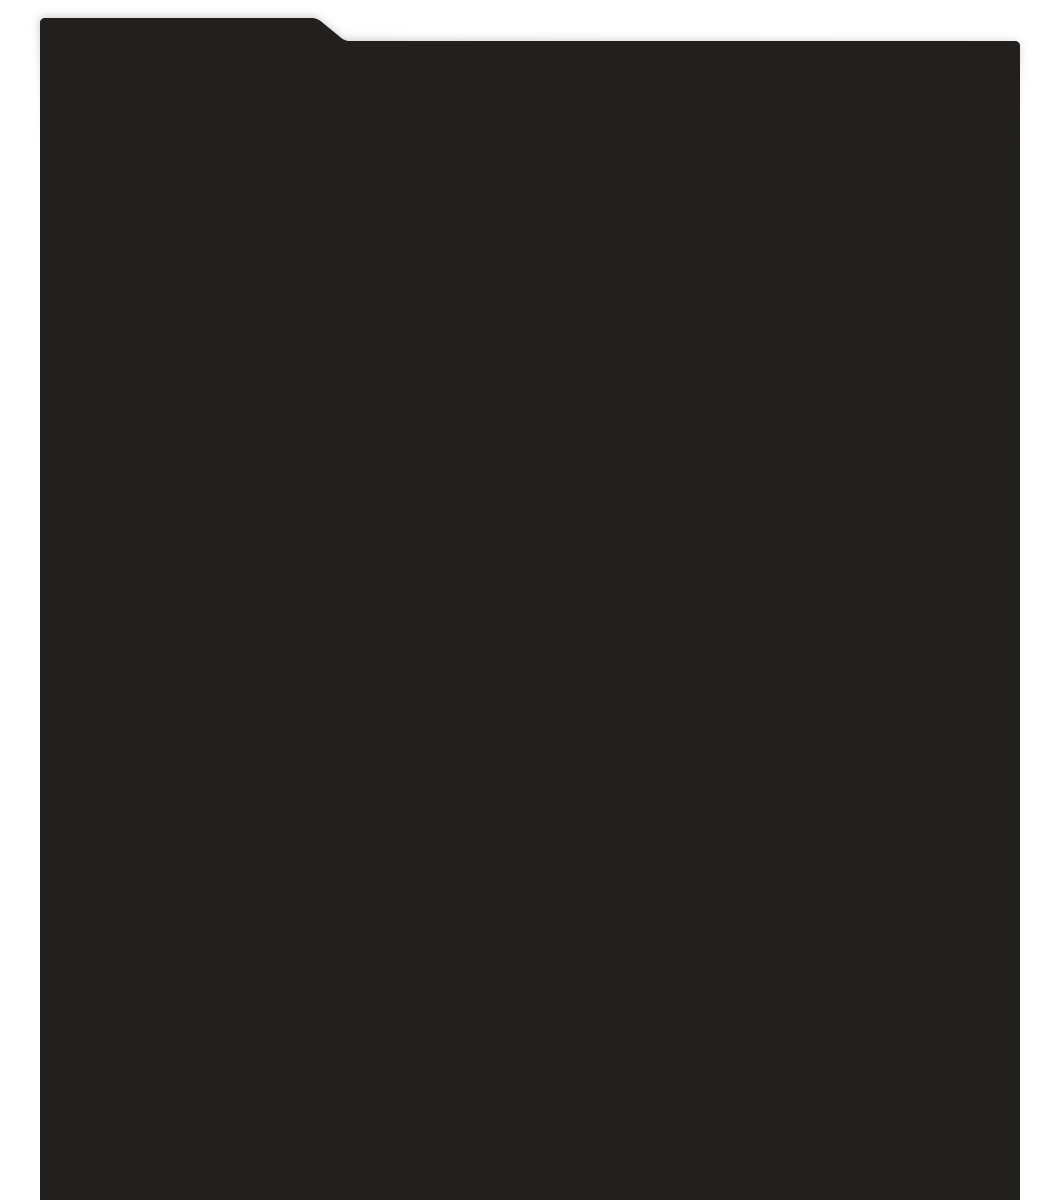
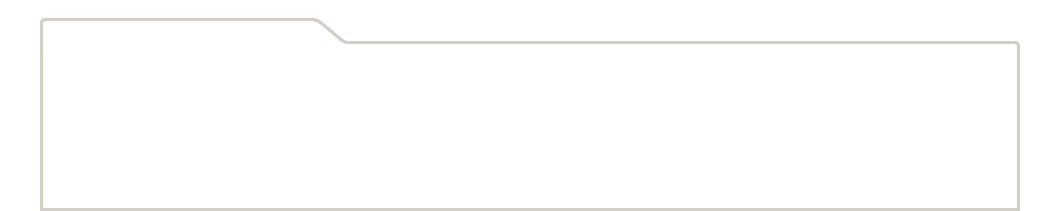
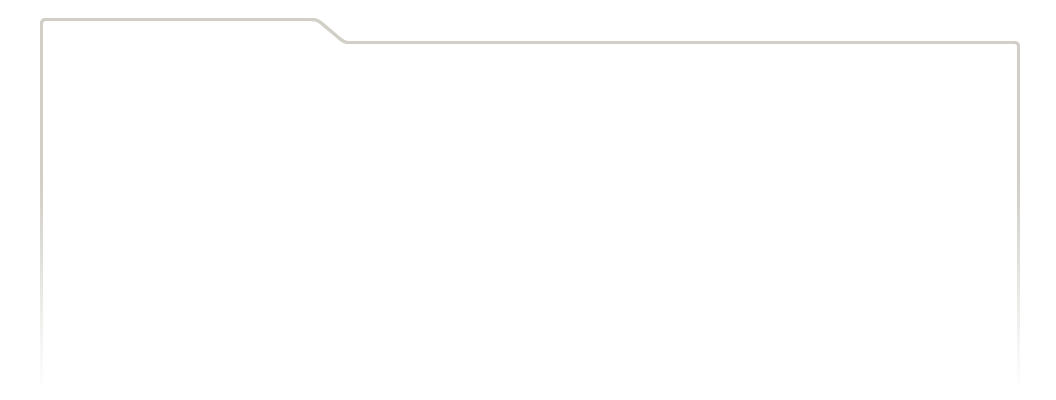
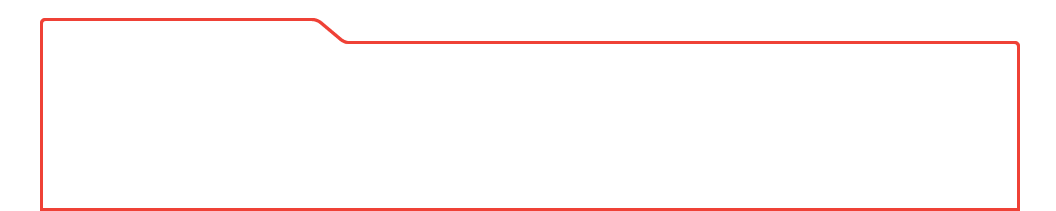
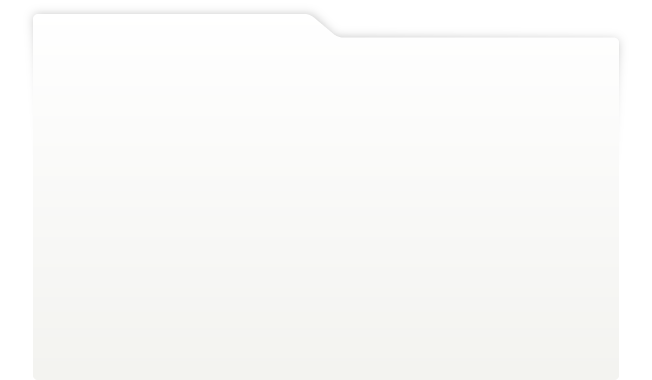
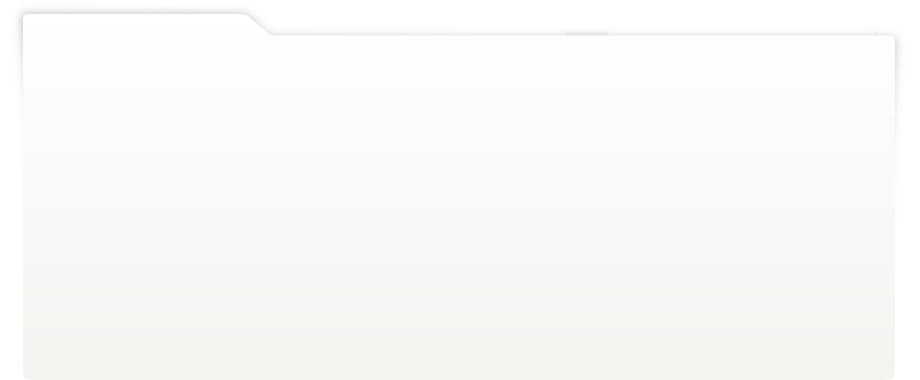
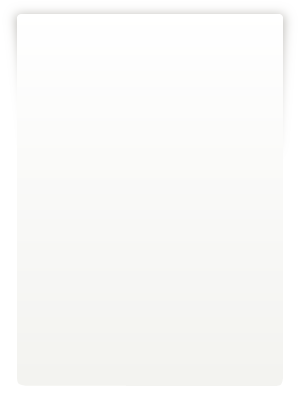
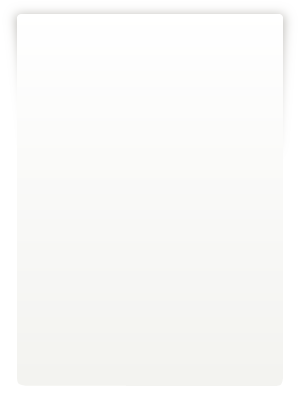
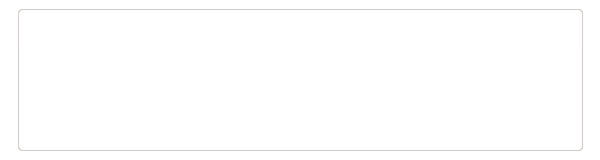
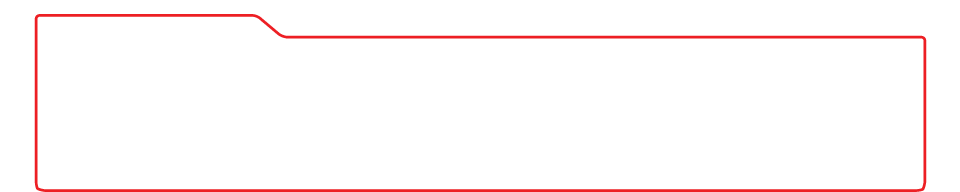
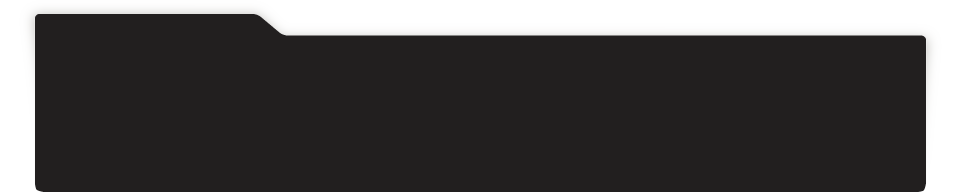
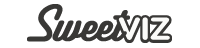
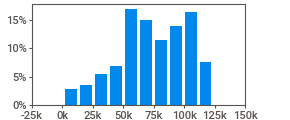
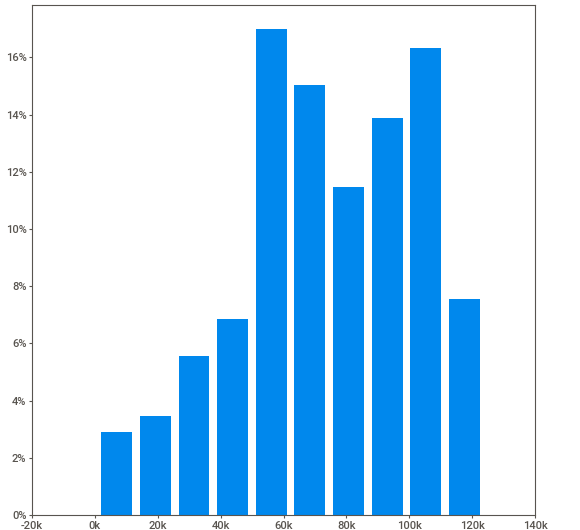
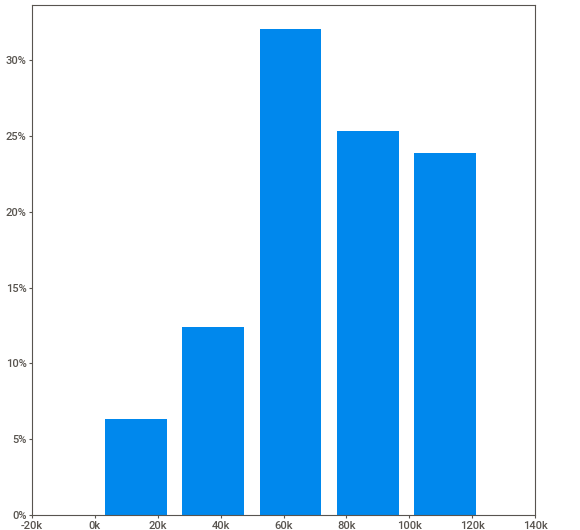
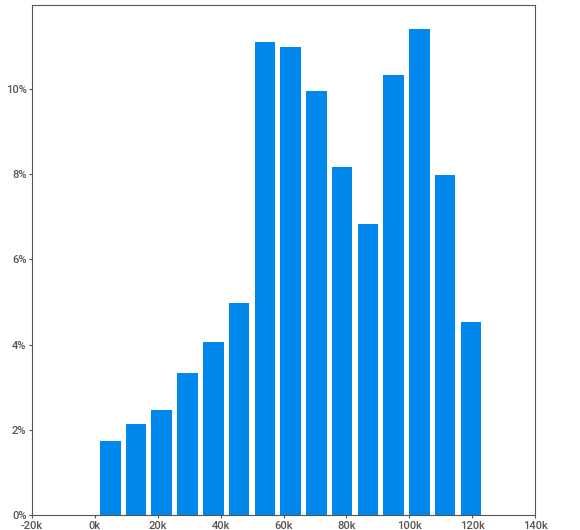
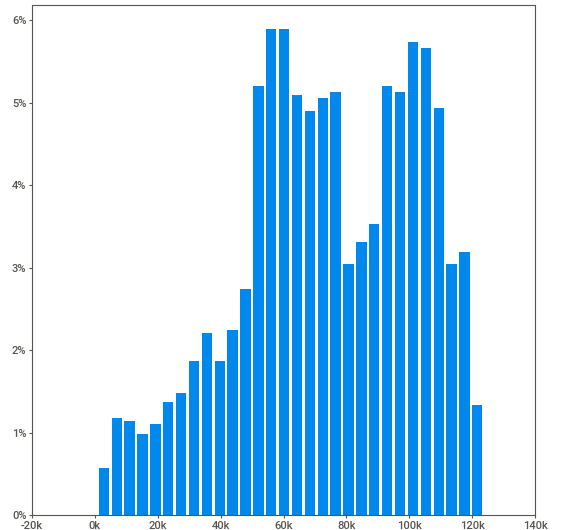
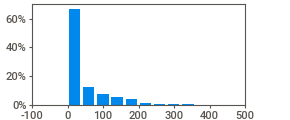
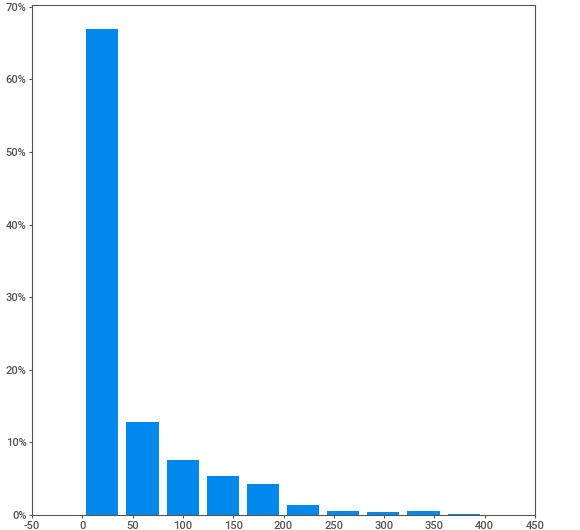
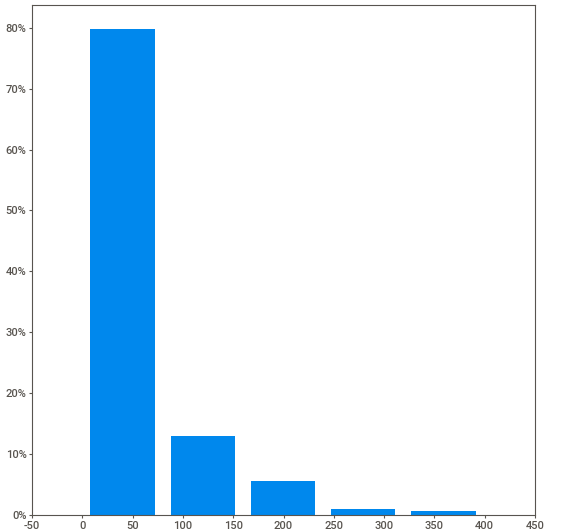
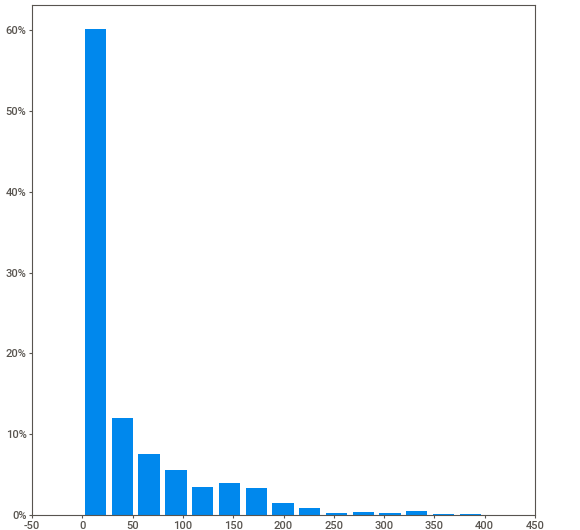
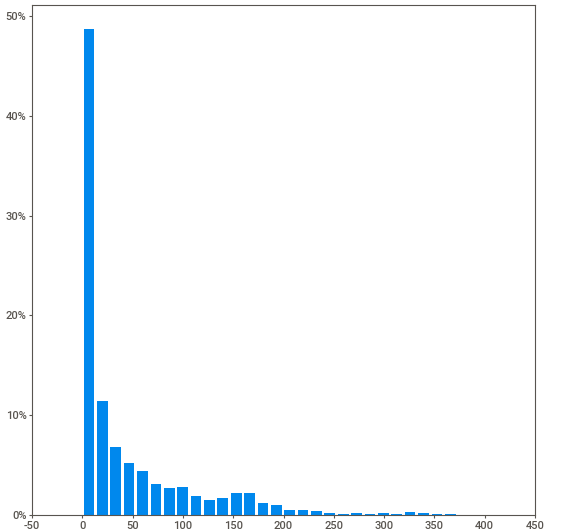
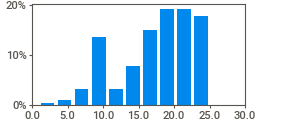
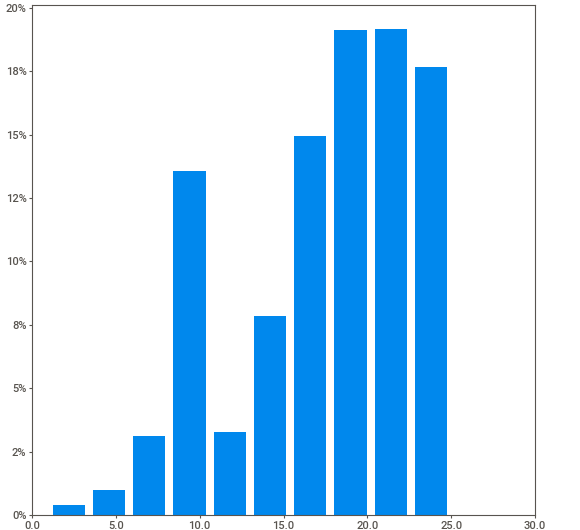
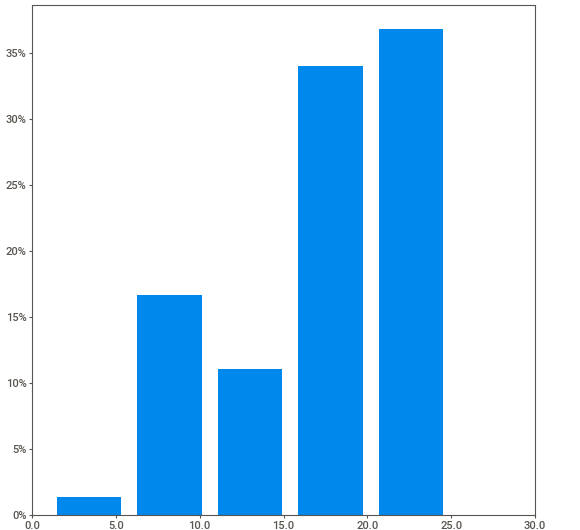
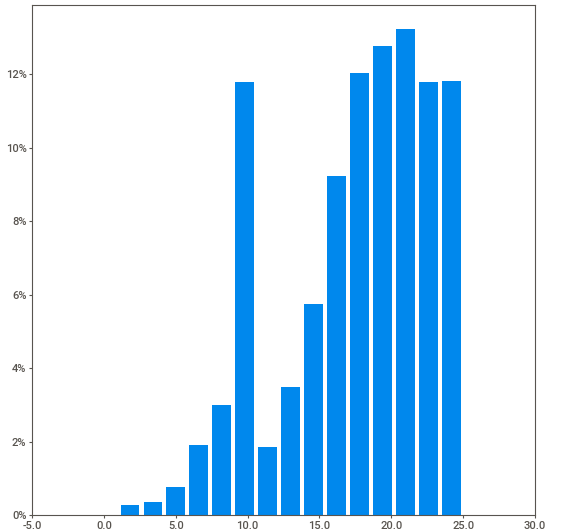
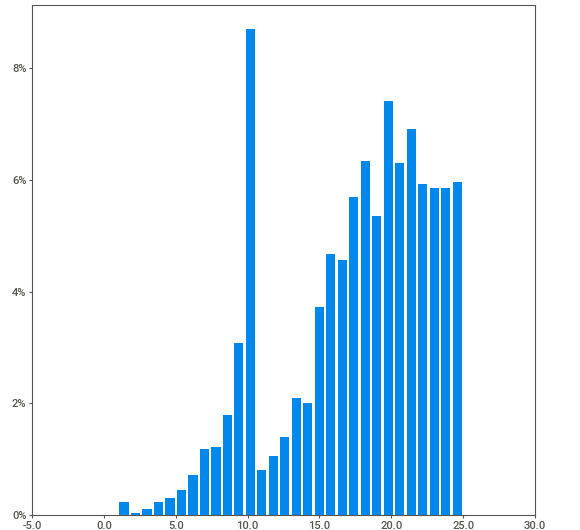
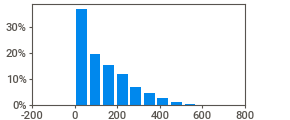
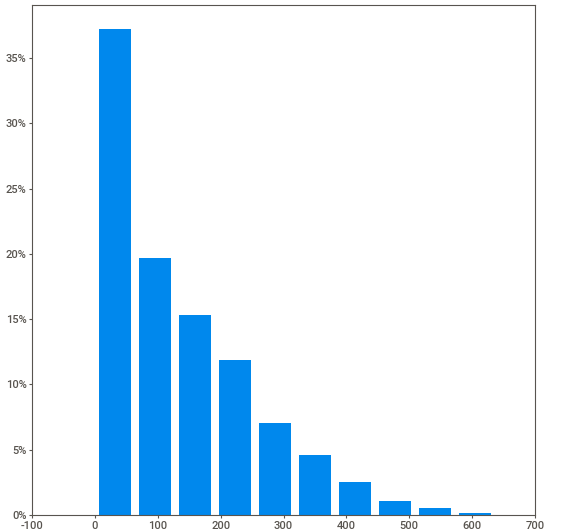
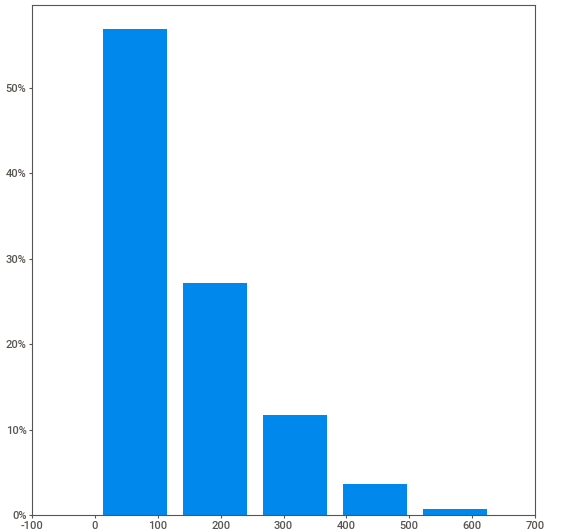
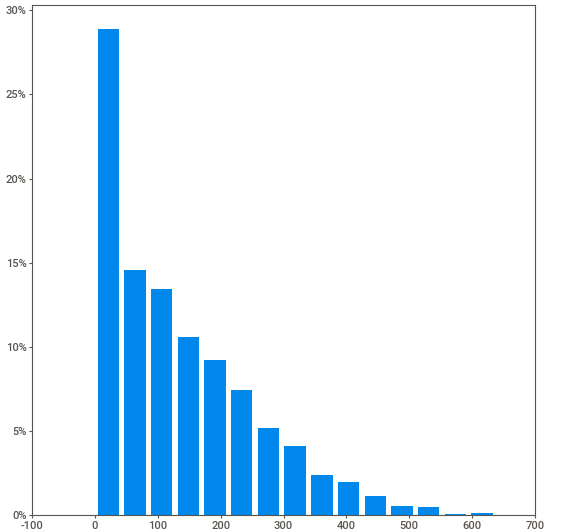
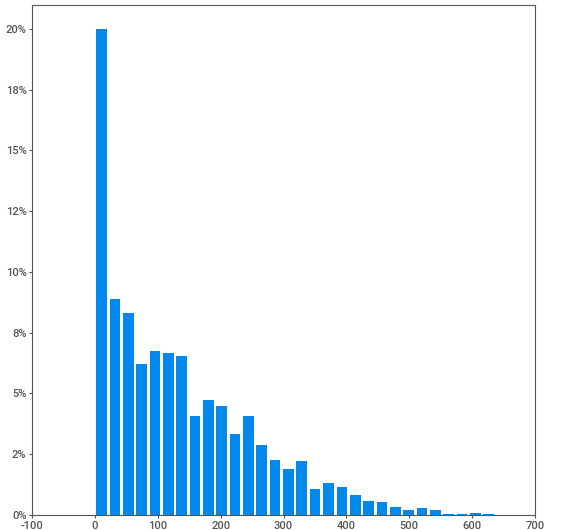
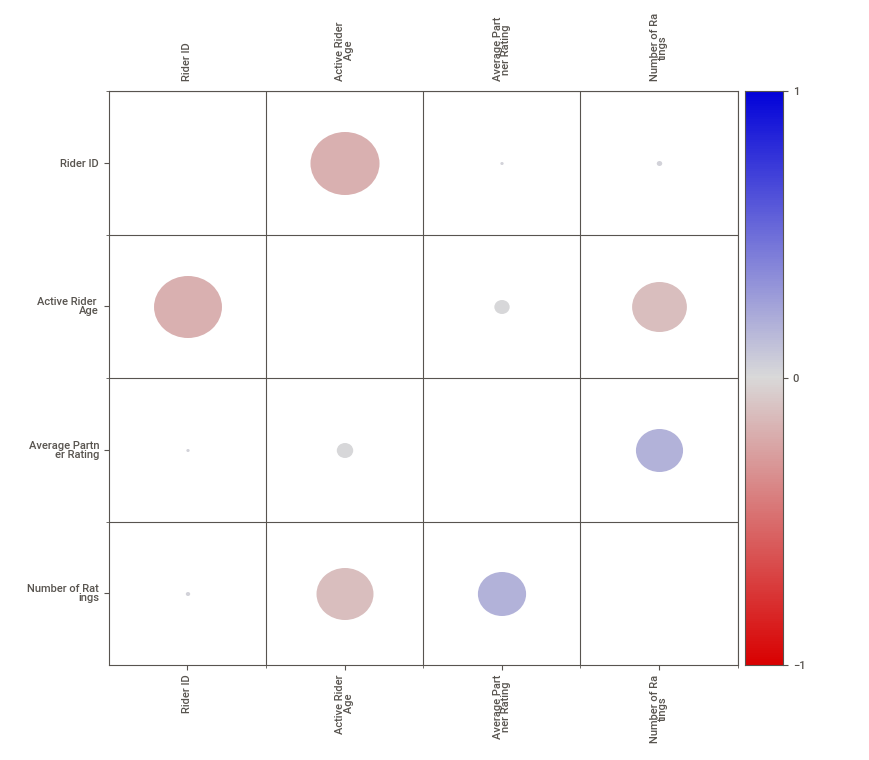
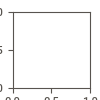

In [18]:
# %perform EDA analysis
r_report = sv.analyze(riders)
r_report.show_notebook()

### ANALYSIS
#### OBSERVATIONS
* Most of rider ratings are below 200 across the platform.
* Most of riders are aged below 100

# Feature Engineering

### Rider Amount Class

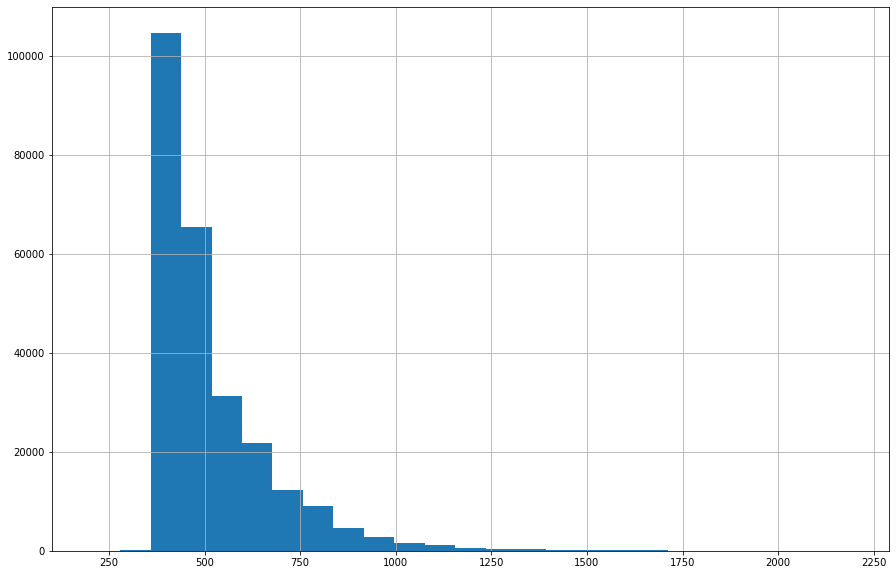

In [13]:
# Let's view the distribution of the rider's payment for the dispatch
hist_amount = df.rider_amount.hist(bins=25,figsize=[15,10])

In [14]:
# create a list of our conditions
conditions = [
    (df['rider_amount'] <= 390),
    (df['rider_amount'] > 390) & (df['rider_amount'] <= 650),
    (df['rider_amount'] > 650) & (df['rider_amount'] <= 820),
    (df['rider_amount'] > 800) & (df['rider_amount'] <= 1200)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '4', '3', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_amount_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)


,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,rider_license_status,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,...,0,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,...,0,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,...,1,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4


### Day of Month

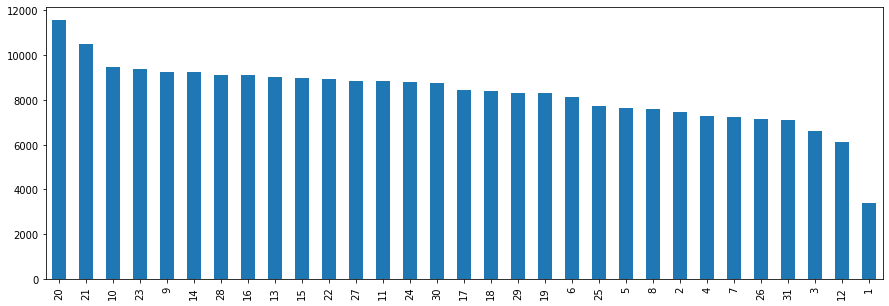

In [16]:
# Dispatches frequency per day of month
df['dispatch_day'].value_counts().plot(kind='bar',figsize=[15,5]);

In [17]:
# create a list of our conditions
conditions = [
    (df['dispatch_day'] == 1),
    (df['dispatch_day'] > 1) & (df['dispatch_day'] <= 6),
    (df['dispatch_day'] > 6) & (df['dispatch_day'] <= 8),
    (df['dispatch_day'] >8)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2','3','4']

# create a new column and use np.select to assign values to it using our lists as arguments
df['dispatch_day_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,rider_carrier_type,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,...,1,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,...,1,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,...,1,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4


### Weekends

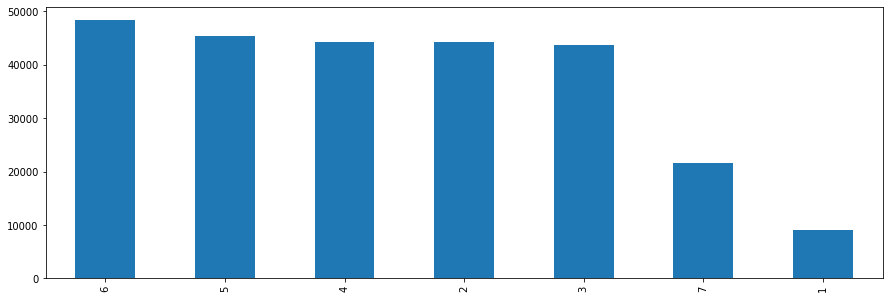

In [18]:
# Dispatches frequency per  weekday
df['dispatch_day_of_week'].value_counts().plot(kind='bar',figsize=[15,5]);

In [19]:
# create a list of our conditions
conditions = [
    (df['dispatch_day_of_week'] == 1),
    (df['dispatch_day_of_week'] == 7)
    ]

# create a list of the values we want to assign for each condition
values = ['2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['weekend'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,rider_amount,rider_lat,rider_long,pickup_lat,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend
0,ID_SCUW21PVAU,4435,27,6,09:02:54,593630,Business,0,2,Bike,...,1080,-42.698343,-17.228539,-42.692371,-17.248305,-42.687442,-17.424682,1,4,0
1,ID_2HA7X30JMN,32711,30,7,13:01:37,837729,Personal,0,1,Bike,...,730,-42.787317,-17.288252,-42.784046,-17.290121,-42.673267,-17.234595,3,4,1
2,ID_IAJWDTBY6M,8712,14,2,10:01:00,695129,Personal,0,2,Bike,...,490,-42.749180,-17.287848,-42.765204,-17.293784,-42.813953,-17.294805,4,4,0


### Busy Hours

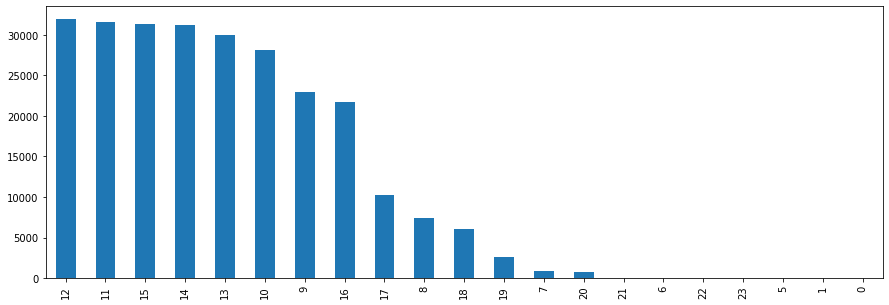

In [20]:
# Convert time column to datetime
df['dispatch_time'] = pd.to_datetime(df['dispatch_time'])

# Extract Hour Column
df['dispatch_hour'] = df['dispatch_time'].dt.hour

# Let's view the hourly distribution of dispatches
df['dispatch_hour'].value_counts().plot(kind='bar',figsize=[15,5]);

In [21]:
# Let's get the cos and cosine of our Time Variable
time_column = ["dispatch_time"]

for col in time_column:
  df[col.split('_')[0] + '_hour_sine'] = np.sin(2 * np.pi * df[col].dt.hour/24)
  df[col.split('_')[0] + '_hour_cos'] = np.cos(2* np.pi * df[col].dt.hour/24)

In [22]:
# create a list of our conditions
conditions = [
    (df['dispatch_hour'] <= 6),
    (df['dispatch_hour'] > 8) & (df['dispatch_hour'] <= 16),
    (df['dispatch_hour'] > 16) & (df['dispatch_hour'] <= 20),
    (df['dispatch_hour'] > 20)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '4', '3', '2']

# create a new column and use np.select to assign values to it using our lists as arguments
df['busy_hours'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,pickup_long,drop_off_lat,drop_off_long,rider_amount_range,dispatch_day_range,weekend,dispatch_hour,dispatch_hour_sine,dispatch_hour_cos,busy_hours
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,-17.248305,-42.687442,-17.424682,1,4,0,9,0.707107,-0.707107,4
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,-17.290121,-42.673267,-17.234595,3,4,1,13,-0.258819,-0.965926,4


In [23]:
def bearing(lat1, lng1, lat2, lng2):
    lon_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    return np.degrees(np.arctan2(np.sin(lon_rad) * np.cos(lat2), np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_rad)))

## Features Interaction:

In [24]:
# create combination feature
df['rider_dispatch_ft'] = df['rider_id'].astype(str) + '-' + df['dispatch_hour'].astype(str)

df['bearing_Rider_PickUp'] = bearing(df['rider_lat'], df['rider_long'], df['pickup_lat'], df['pickup_long'])

# create agg per order_id 
distance_statistics = df.groupby(by="order_id",as_index=False).agg({'bearing_Rider_PickUp':['mean','min','max','std'],})
distance_statistics.columns = ["_By_OrderId_".join(x) for x in distance_statistics.columns.ravel()]
df = pd.merge(df,distance_statistics,how="left",right_on="order_id_By_OrderId_",left_on="order_id")
del df['order_id_By_OrderId_']

### Label encode "rider_dispatch_ft" feature:

In [25]:
LE = LabelEncoder()
LE_features = ['rider_dispatch_ft']               
for feature in LE_features :
  df[feature] = LE.fit_transform(df[feature].astype(str))

## Geo Distance

In [26]:
# Calculate distance between coordinates

def distance_calc(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    AVG_EARTH_RADIUS = 6371  # in km
    
    lat = lat2 - lat1
    
    lng = lng2 - lng1
    
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h




# Let's create variables for the distances between the locations of the riders, pickup points and dropoff points
df['rider_dropoff_dist'] = distance_calc(df.rider_lat, df.rider_long, df.drop_off_lat, df.drop_off_long)
df['rider_pickup_dist'] = distance_calc(df.rider_lat, df.rider_long, df.pickup_lat, df.pickup_long)
df['pickup_dropoff_dist'] = distance_calc(df.pickup_lat, df.pickup_long, df.drop_off_lat, df.drop_off_long)

### Distance Ranges
#### Pickup Drop_off ranges

<AxesSubplot:>

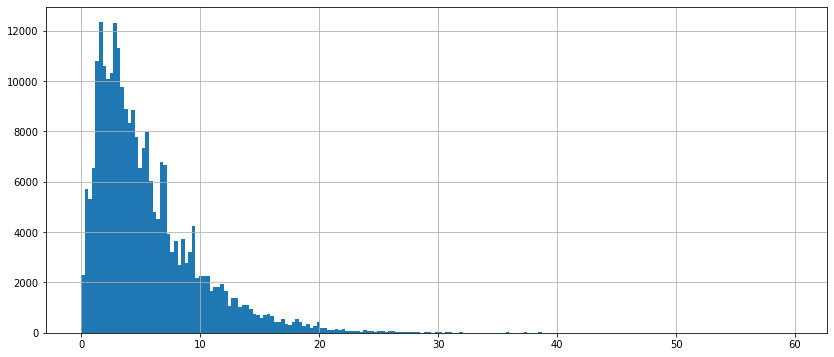

In [27]:
# We can now view the distribution of the distance between pickup and drop off locations

bin_values = np.arange(start=-0, stop=60, step=0.3)
df['pickup_dropoff_dist'].hist(bins=bin_values, figsize=[14,6])

In [28]:
# create a list of our conditions
conditions = [
    (df['pickup_dropoff_dist'] <= 6),
    (df['pickup_dropoff_dist'] > 6) & (df['pickup_dropoff_dist'] <= 16),
    (df['pickup_dropoff_dist'] > 16) & (df['pickup_dropoff_dist'] <= 30),
    (df['pickup_dropoff_dist'] > 30) & (df['pickup_dropoff_dist'] <= 50),
    (df['pickup_dropoff_dist'] > 50)
    ]

# create a list of the values we want to assign for each condition
values = ['5','4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['pickup_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,rider_dispatch_ft,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,3076,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,2743,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4


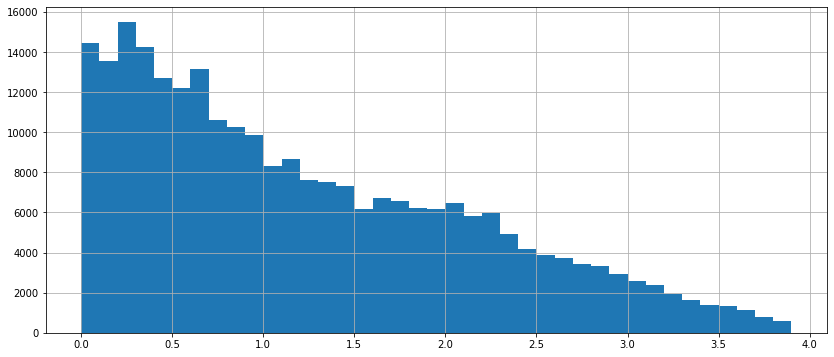

In [29]:
# Let's also look at distribution of the distance between the rider and the pickup location

bin_values = np.arange(start=-0, stop=4, step=0.1)
df['rider_pickup_dist'].hist(bins=bin_values, figsize=[14,6]);

In [30]:
# create a list of our conditions
conditions = [
    (df['rider_pickup_dist'] <= 1),
    (df['rider_pickup_dist'] > 1) & (df['rider_pickup_dist'] <= 1.5),
    (df['rider_pickup_dist'] > 1.5) & (df['rider_pickup_dist'] <= 2.5),
    (df['rider_pickup_dist'] > 2.5) & (df['rider_pickup_dist'] <= 3.7),
    (df['rider_pickup_dist'] > 3.7)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_pickup_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,bearing_Rider_PickUp,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,-67.659597,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,-22.752722,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1
2,ID_IAJWDTBY6M,8712,14,2,2022-05-28 10:01:00,695129,Personal,0,2,Bike,...,-164.786368,-19.722334,-164.786368,165.004835,110.149486,7.224872,1.846564,5.421337,5,3


#### Rider Drop_off_Ranges

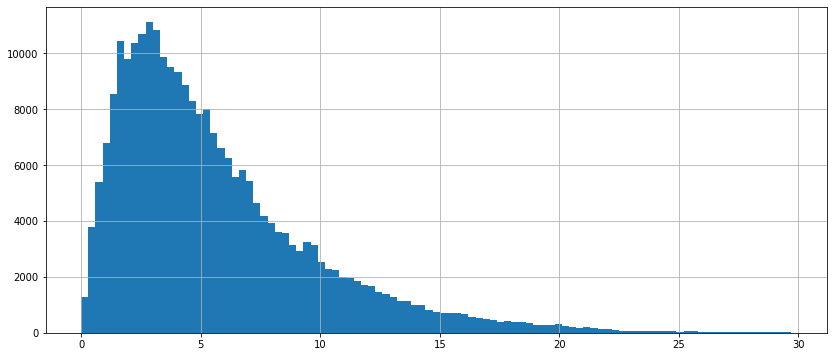

In [31]:
# Let's also visualize the distance between the rider and drop off location

bin_values = np.arange(start=-0, stop=30, step=0.3)
df['rider_dropoff_dist'].hist(bins=bin_values, figsize=[14,6]);
plt.title()

In [32]:
# create a list of our conditions
conditions = [
    (df['rider_dropoff_dist'] <= 5),
    (df['rider_dropoff_dist'] > 5) & (df['rider_dropoff_dist'] <= 10),
    (df['rider_dropoff_dist'] > 10) & (df['rider_dropoff_dist'] <= 18),
    (df['rider_dropoff_dist'] > 18) & (df['rider_dropoff_dist'] <= 30),
    (df['rider_dropoff_dist'] > 30)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['rider_dropoff_dist_range'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,bearing_Rider_PickUp_By_OrderId_mean,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,-52.037239,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,-22.752722,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3
2,ID_IAJWDTBY6M,8712,14,2,2022-05-28 10:01:00,695129,Personal,0,2,Bike,...,-19.722334,-164.786368,165.004835,110.149486,7.224872,1.846564,5.421337,5,3,2


#### Time and Distance

In [33]:
# create a list of our conditions
conditions = [
    (df['rider_dropoff_dist_range'] == '5') & (df['busy_hours'] == '1'),
    (df['rider_dropoff_dist_range'] == '4') & (df['busy_hours'] == '2'),
    (df['rider_dropoff_dist_range'] == '3') & (df['busy_hours'] == '3'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '1') & (df['busy_hours'] == '4'),
    (df['rider_dropoff_dist_range'] == '2') & (df['busy_hours'] == '0')
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','6','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,bearing_Rider_PickUp_By_OrderId_min,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,-70.030817,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3,0
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,-22.752722,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3,0


#### Weekday vs Time Distance

In [34]:
# create a list of our conditions
conditions = [
    (df['dispatch_day_of_week'] == '1') & (df['time_distance_bias'] == '5'), # Sunday  early morning & average distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '3'), # Saturday late night & long distance
    (df['dispatch_day_of_week'] == '7') & (df['time_distance_bias'] == '5'), # Saturday early morning average distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '3'), # Weekday late night & long distance
    (df['dispatch_day_of_week'] == '0') & (df['time_distance_bias'] == '6')  # Weekday daytime and average distance
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2', '3', '4','5']

# create a new column and use np.select to assign values to it using our lists as arguments
df['weekend_time_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(2)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,bearing_Rider_PickUp_By_OrderId_max,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,-18.421302,29.136388,16.076117,1.746491,14.426076,4,3,3,0,0
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,-22.752722,NaN,13.417651,0.394373,13.126454,4,1,3,0,0


#### Money earned vs Time and Distance

In [35]:
# create a list of our conditions
conditions = [
    (df['rider_amount_range'] == '4') & (df['busy_hours'] == '4'),
    (df['rider_pickup_dist_range'] == '3') & (df['busy_hours'] == '2'),
    (df['rider_pickup_dist_range'] == '1') & (df['rider_amount_range'] == '4'),
    (df['rider_pickup_dist_range'] == '4') & (df['rider_amount_range'] == '4')
    ]

# create a list of the values we want to assign for each condition
values = ['4','2','6','1']

# create a new column and use np.select to assign values to it using our lists as arguments
df['money_distance_bias'] = np.select(conditions, values)

# display updated DataFrame
df.head(3)

,ID,order_id,dispatch_day,dispatch_day_of_week,dispatch_time,client_id,client_type,order_license_status,order_carrier_type,vendor_type,...,bearing_Rider_PickUp_By_OrderId_std,rider_dropoff_dist,rider_pickup_dist,pickup_dropoff_dist,pickup_dropoff_dist_range,rider_pickup_dist_range,rider_dropoff_dist_range,time_distance_bias,weekend_time_distance_bias,money_distance_bias
0,ID_SCUW21PVAU,4435,27,6,2022-05-28 09:02:54,593630,Business,0,2,Bike,...,29.136388,16.076117,1.746491,14.426076,4,3,3,0,0,0
1,ID_2HA7X30JMN,32711,30,7,2022-05-28 13:01:37,837729,Personal,0,1,Bike,...,NaN,13.417651,0.394373,13.126454,4,1,3,0,0,0
2,ID_IAJWDTBY6M,8712,14,2,2022-05-28 10:01:00,695129,Personal,0,2,Bike,...,110.149486,7.224872,1.846564,5.421337,5,3,2,4,0,4


In [36]:
# let's convert some string columns to numeric
df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']] = df[['rider_dropoff_dist_range',	'time_distance_bias',	'weekend_time_distance_bias','busy_hours','weekend','money_distance_bias']].apply(pd.to_numeric)

# Modelling:
## CatBoostClassifier (without KFolds)

In [37]:
# Split train and test set
train = df.iloc[:179867, :]
test = df.iloc[179867:, :]

In [38]:
# Selecting the columns to be used as data for accuracy testing
cols = [col for col in train.columns if col not in ['dispatch_time', 'ID']]

# Set the target and independent variables
X = train[cols]
y = target
test=test[cols]

In [39]:
km = KMeans(n_clusters=7)

In [40]:
def encoder(train, test):
  le = LabelEncoder()
  for col in train.select_dtypes("object").columns:
    train[col]=le.fit_transform(train[col])
    test[col]=le.transform(test[col])
  return train, test

In [41]:
X_enc, test_enc = encoder(X, test)
X_enc.isna().sum()[X_enc.isna().sum()!=0]

bearing_Rider_PickUp_By_OrderId_std    8423
dtype: int64

In [42]:
X_enc.fillna(X_enc.mean(), inplace=True)

test_enc.fillna(test_enc.mean(), inplace=True)

In [43]:
X["cluster"]=km.fit_predict(X_enc)
test["cluster"]=km.predict(test_enc)

In [44]:
X.bearing_Rider_PickUp_By_OrderId_std.fillna(X.bearing_Rider_PickUp_By_OrderId_std.mean(), inplace=True)
test.bearing_Rider_PickUp_By_OrderId_std.fillna(test.bearing_Rider_PickUp_By_OrderId_std.mean(), inplace=True)

In [45]:
try:
  test.drop(['dispatch_time', 'ID'],axis = 1, inplace=True)
except:
  pass

In [46]:
skf = StratifiedKFold(5,True, 34)

In [48]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights

array([0.60965871, 1.31415441, 1.67002776])

In [49]:
# You can increase the iterations parameter but it will take longer to learn
model = CatBoostClassifier(iterations = 1000, early_stopping_rounds = 50, random_state=50, learning_rate=0.103116,
                          class_weights=class_weights
                           )

In [50]:
# Here we fit our data then make predictions

# Since Catboost accepts categorical features we'll make then identifiable to the model 
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Fitting our data to the model
model.fit(X,y,cat_features=categorical_features_indices)

# Making Predictions
y_pred = model.predict(test)
model.score(X,y)

0:	learn: 1.0574294	total: 2.19s	remaining: 36m 27s
1:	learn: 1.0246554	total: 4.46s	remaining: 37m 3s
2:	learn: 0.9975282	total: 6.6s	remaining: 36m 34s
3:	learn: 0.9755931	total: 8.82s	remaining: 36m 36s
4:	learn: 0.9514223	total: 11.4s	remaining: 37m 56s
5:	learn: 0.9300224	total: 14s	remaining: 38m 47s
6:	learn: 0.9115975	total: 16.5s	remaining: 38m 55s
7:	learn: 0.8964910	total: 18.9s	remaining: 39m 3s
8:	learn: 0.8831760	total: 21s	remaining: 38m 31s
9:	learn: 0.8712315	total: 23.1s	remaining: 38m 6s
10:	learn: 0.8624331	total: 25.1s	remaining: 37m 40s
11:	learn: 0.8538193	total: 27.7s	remaining: 37m 58s
12:	learn: 0.8462924	total: 30.1s	remaining: 38m 2s
13:	learn: 0.8395630	total: 32.2s	remaining: 37m 47s
14:	learn: 0.8307550	total: 34.2s	remaining: 37m 28s
15:	learn: 0.8237073	total: 36.2s	remaining: 37m 7s
16:	learn: 0.8172238	total: 38.3s	remaining: 36m 55s
17:	learn: 0.8116088	total: 40.3s	remaining: 36m 39s
18:	learn: 0.8073322	total: 42.2s	remaining: 36m 16s
19:	learn: 0.

153:	learn: 0.6931954	total: 7m 12s	remaining: 39m 34s
154:	learn: 0.6930569	total: 7m 15s	remaining: 39m 32s
155:	learn: 0.6929743	total: 7m 18s	remaining: 39m 30s
156:	learn: 0.6928487	total: 7m 21s	remaining: 39m 30s
157:	learn: 0.6926038	total: 7m 24s	remaining: 39m 30s
158:	learn: 0.6923593	total: 7m 28s	remaining: 39m 30s
159:	learn: 0.6922569	total: 7m 31s	remaining: 39m 29s
160:	learn: 0.6921726	total: 7m 34s	remaining: 39m 28s
161:	learn: 0.6919350	total: 7m 37s	remaining: 39m 27s
162:	learn: 0.6916840	total: 7m 41s	remaining: 39m 28s
163:	learn: 0.6915004	total: 7m 45s	remaining: 39m 30s
164:	learn: 0.6912701	total: 7m 48s	remaining: 39m 29s
165:	learn: 0.6910071	total: 7m 51s	remaining: 39m 28s
166:	learn: 0.6908984	total: 7m 54s	remaining: 39m 28s
167:	learn: 0.6906448	total: 7m 58s	remaining: 39m 27s
168:	learn: 0.6904920	total: 8m 1s	remaining: 39m 26s
169:	learn: 0.6903778	total: 8m 4s	remaining: 39m 24s
170:	learn: 0.6902637	total: 8m 7s	remaining: 39m 23s
171:	learn: 0

302:	learn: 0.6745868	total: 15m 18s	remaining: 35m 13s
303:	learn: 0.6745567	total: 15m 21s	remaining: 35m 9s
304:	learn: 0.6744683	total: 15m 25s	remaining: 35m 7s
305:	learn: 0.6743284	total: 15m 28s	remaining: 35m 5s
306:	learn: 0.6742751	total: 15m 31s	remaining: 35m 2s
307:	learn: 0.6739416	total: 15m 34s	remaining: 35m
308:	learn: 0.6739141	total: 15m 37s	remaining: 34m 56s
309:	learn: 0.6737934	total: 15m 40s	remaining: 34m 53s
310:	learn: 0.6737766	total: 15m 43s	remaining: 34m 51s
311:	learn: 0.6737214	total: 15m 47s	remaining: 34m 48s
312:	learn: 0.6736927	total: 15m 50s	remaining: 34m 45s
313:	learn: 0.6736576	total: 15m 53s	remaining: 34m 42s
314:	learn: 0.6735596	total: 15m 56s	remaining: 34m 40s
315:	learn: 0.6734557	total: 16m	remaining: 34m 38s
316:	learn: 0.6733415	total: 16m 3s	remaining: 34m 35s
317:	learn: 0.6732581	total: 16m 6s	remaining: 34m 32s
318:	learn: 0.6731313	total: 16m 9s	remaining: 34m 29s
319:	learn: 0.6731189	total: 16m 12s	remaining: 34m 26s
320:	le

450:	learn: 0.6653272	total: 23m 15s	remaining: 28m 19s
451:	learn: 0.6652959	total: 23m 18s	remaining: 28m 16s
452:	learn: 0.6652363	total: 23m 21s	remaining: 28m 12s
453:	learn: 0.6652229	total: 23m 24s	remaining: 28m 9s
454:	learn: 0.6651793	total: 23m 27s	remaining: 28m 6s
455:	learn: 0.6651612	total: 23m 30s	remaining: 28m 3s
456:	learn: 0.6650917	total: 23m 33s	remaining: 27m 59s
457:	learn: 0.6650059	total: 23m 36s	remaining: 27m 56s
458:	learn: 0.6649554	total: 23m 39s	remaining: 27m 53s
459:	learn: 0.6647377	total: 23m 43s	remaining: 27m 50s
460:	learn: 0.6646969	total: 23m 46s	remaining: 27m 48s
461:	learn: 0.6645856	total: 23m 50s	remaining: 27m 45s
462:	learn: 0.6645712	total: 23m 53s	remaining: 27m 42s
463:	learn: 0.6644806	total: 23m 56s	remaining: 27m 39s
464:	learn: 0.6644316	total: 23m 59s	remaining: 27m 36s
465:	learn: 0.6643770	total: 24m 3s	remaining: 27m 34s
466:	learn: 0.6640739	total: 24m 6s	remaining: 27m 30s
467:	learn: 0.6640532	total: 24m 9s	remaining: 27m 27

598:	learn: 0.6571855	total: 31m 11s	remaining: 20m 52s
599:	learn: 0.6570940	total: 31m 14s	remaining: 20m 49s
600:	learn: 0.6570140	total: 31m 18s	remaining: 20m 46s
601:	learn: 0.6569863	total: 31m 21s	remaining: 20m 43s
602:	learn: 0.6569290	total: 31m 24s	remaining: 20m 40s
603:	learn: 0.6568533	total: 31m 28s	remaining: 20m 37s
604:	learn: 0.6567911	total: 31m 31s	remaining: 20m 34s
605:	learn: 0.6567589	total: 31m 34s	remaining: 20m 31s
606:	learn: 0.6567184	total: 31m 37s	remaining: 20m 28s
607:	learn: 0.6566902	total: 31m 40s	remaining: 20m 25s
608:	learn: 0.6566591	total: 31m 43s	remaining: 20m 22s
609:	learn: 0.6566006	total: 31m 46s	remaining: 20m 19s
610:	learn: 0.6565265	total: 31m 50s	remaining: 20m 16s
611:	learn: 0.6564829	total: 31m 52s	remaining: 20m 12s
612:	learn: 0.6564242	total: 31m 55s	remaining: 20m 9s
613:	learn: 0.6563955	total: 31m 59s	remaining: 20m 6s
614:	learn: 0.6563472	total: 32m 2s	remaining: 20m 3s
615:	learn: 0.6563171	total: 32m 6s	remaining: 20m
6

746:	learn: 0.6505569	total: 39m 8s	remaining: 13m 15s
747:	learn: 0.6505078	total: 39m 11s	remaining: 13m 12s
748:	learn: 0.6504805	total: 39m 15s	remaining: 13m 9s
749:	learn: 0.6504449	total: 39m 18s	remaining: 13m 6s
750:	learn: 0.6504141	total: 39m 21s	remaining: 13m 2s
751:	learn: 0.6503617	total: 39m 24s	remaining: 12m 59s
752:	learn: 0.6503356	total: 39m 28s	remaining: 12m 56s
753:	learn: 0.6503006	total: 39m 31s	remaining: 12m 53s
754:	learn: 0.6502335	total: 39m 34s	remaining: 12m 50s
755:	learn: 0.6502081	total: 39m 38s	remaining: 12m 47s
756:	learn: 0.6502022	total: 39m 41s	remaining: 12m 44s
757:	learn: 0.6501349	total: 39m 44s	remaining: 12m 41s
758:	learn: 0.6500981	total: 39m 48s	remaining: 12m 38s
759:	learn: 0.6500404	total: 39m 51s	remaining: 12m 35s
760:	learn: 0.6500188	total: 39m 54s	remaining: 12m 32s
761:	learn: 0.6499637	total: 39m 58s	remaining: 12m 29s
762:	learn: 0.6499563	total: 40m 1s	remaining: 12m 25s
763:	learn: 0.6499355	total: 40m 4s	remaining: 12m 22

896:	learn: 0.6446024	total: 47m 7s	remaining: 5m 24s
897:	learn: 0.6445862	total: 47m 10s	remaining: 5m 21s
898:	learn: 0.6445252	total: 47m 14s	remaining: 5m 18s
899:	learn: 0.6444818	total: 47m 17s	remaining: 5m 15s
900:	learn: 0.6444721	total: 47m 20s	remaining: 5m 12s
901:	learn: 0.6444078	total: 47m 23s	remaining: 5m 8s
902:	learn: 0.6443792	total: 47m 26s	remaining: 5m 5s
903:	learn: 0.6442920	total: 47m 29s	remaining: 5m 2s
904:	learn: 0.6442573	total: 47m 32s	remaining: 4m 59s
905:	learn: 0.6442222	total: 47m 35s	remaining: 4m 56s
906:	learn: 0.6441831	total: 47m 38s	remaining: 4m 53s
907:	learn: 0.6441551	total: 47m 41s	remaining: 4m 49s
908:	learn: 0.6440522	total: 47m 45s	remaining: 4m 46s
909:	learn: 0.6440017	total: 47m 49s	remaining: 4m 43s
910:	learn: 0.6439702	total: 47m 52s	remaining: 4m 40s
911:	learn: 0.6439437	total: 47m 55s	remaining: 4m 37s
912:	learn: 0.6439229	total: 47m 58s	remaining: 4m 34s
913:	learn: 0.6438701	total: 48m 1s	remaining: 4m 31s
914:	learn: 0.6

0.041063674826399506

In [51]:
# Let's create a submission file to input our predictions
submissionFile= pd.DataFrame({"ID":df_test["ID"]})
submissionFile['target'] = y_pred

In [52]:
# Saving our data in a CSV

submissionFile.to_csv("Submissions.csv",index=False) 